## 1. Import Libraries


In [1]:
# Standard libraries
import os
import sys
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handlingdo
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.models import VGG19_Weights

# Configuration
import yaml

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Load Configuration

In [2]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
dataset_root = project_root / 'data' / 'zalando-hd-resized'
processed_dir = project_root / 'data' / 'processed'
output_dir = project_root / 'outputs' / 'dataset'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project Root: {project_root}")
print(f"📁 Dataset Root: {dataset_root}")
print(f"📁 Processed Data: {processed_dir}")
print(f"📁 Output Directory: {output_dir}")

# Load configurations
with open(processed_dir / 'preprocessing_config.yaml', 'r') as f:
    preprocess_config = yaml.load(f, Loader=yaml.FullLoader)

with open(project_root / 'outputs' / 'cloth_agnostic' / 'cloth_agnostic_config.json', 'r') as f:
    ca_config = json.load(f)

print("\n✅ Loaded configurations")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Load dataset catalogs
train_catalog = pd.read_csv(processed_dir / 'train_catalog.csv')
val_catalog = pd.read_csv(processed_dir / 'val_catalog.csv')
test_catalog = pd.read_csv(processed_dir / 'test_catalog.csv')

print(f"\n📊 Dataset: {len(train_catalog)} train, {len(val_catalog)} val, {len(test_catalog)} test")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
📁 Processed Data: d:\Projects\AI-Virtual-TryOn\data\processed
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\dataset

✅ Loaded configurations

🖥️ Using device: cuda

📊 Dataset: 10482 train, 1165 val, 2032 test


## 3. Define Helper Functions

Reuse functions from previous notebooks.

In [3]:
def load_pose_keypoints(json_path: str) -> np.ndarray:
    """Load pose keypoints from OpenPose JSON."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    if 'people' in data and len(data['people']) > 0:
        pose_keypoints = data['people'][0]['pose_keypoints_2d']
        keypoints = np.array(pose_keypoints).reshape(-1, 3)
        return keypoints
    else:
        return np.zeros((25, 3))


def create_pose_heatmaps(keypoints: np.ndarray, 
                        image_size: Tuple[int, int],
                        sigma: float = 3.0) -> np.ndarray:
    """Create Gaussian heatmaps from keypoints."""
    h, w = image_size
    heatmaps = np.zeros((18, h, w), dtype=np.float32)  # 18 channels
    
    y_grid, x_grid = np.ogrid[:h, :w]
    
    for i in range(18):  # Only first 18 keypoints
        x, y, conf = keypoints[i]
        if conf > 0.1:
            x, y = int(x), int(y)
            if 0 <= x < w and 0 <= y < h:
                heatmap = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))
                heatmaps[i] = heatmap * conf
    
    return heatmaps


def parsing_to_onehot(parsing: np.ndarray, num_classes: int = 20) -> np.ndarray:
    """Convert parsing mask to one-hot encoding."""
    h, w = parsing.shape
    onehot = np.zeros((num_classes, h, w), dtype=np.float32)
    
    for i in range(num_classes):
        onehot[i][parsing == i] = 1.0
    
    return onehot


def create_cloth_agnostic_mask(parsing: np.ndarray,
                               garment_classes: List[int] = [5, 7]) -> np.ndarray:
    """Create cloth-agnostic mask by removing garment."""
    mask = np.ones_like(parsing, dtype=np.uint8)
    
    for cls_id in garment_classes:
        mask[parsing == cls_id] = 0
    
    return mask


print("✅ Helper functions defined")

✅ Helper functions defined


## 4. Data Augmentation Pipeline

In [4]:
class VITONAugmentation:
    """
    Data augmentation for virtual try-on.
    Applies synchronized augmentation to all modalities.
    """
    
    def __init__(self, 
                 is_train: bool = True,
                 horizontal_flip_prob: float = 0.5,
                 color_jitter_prob: float = 0.3):
        self.is_train = is_train
        self.horizontal_flip_prob = horizontal_flip_prob
        self.color_jitter_prob = color_jitter_prob
        
        # Color jitter for RGB images only
        self.color_jitter = T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        )
    
    def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """
        Apply augmentation to all data modalities.
        """
        if not self.is_train:
            return data
        
        # Horizontal flip (synchronized across all modalities)
        if torch.rand(1).item() < self.horizontal_flip_prob:
            data = self._horizontal_flip(data)
        
        # Color jitter (only for RGB images)
        if torch.rand(1).item() < self.color_jitter_prob:
            data = self._apply_color_jitter(data)
        
        return data
    
    def _horizontal_flip(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """Apply horizontal flip to all modalities."""
        # Flip image tensors
        for key in ['person_image', 'cloth_image', 'cloth_agnostic', 
                    'pose_map', 'parsing_onehot', 'ca_mask']:
            if key in data:
                data[key] = TF.hflip(data[key])
        
        # Swap left/right keypoints if needed
        # This would require more complex logic for pose keypoints
        
        return data
    
    def _apply_color_jitter(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """Apply color jitter to RGB images only."""
        for key in ['person_image', 'cloth_image']:
            if key in data:
                data[key] = self.color_jitter(data[key])
        
        return data


print("✅ Augmentation pipeline defined")

✅ Augmentation pipeline defined


## 5. VITONDataset Class

In [5]:
class VITONDataset(Dataset):
    """
    PyTorch Dataset for Virtual Try-On (VITON-HD).
    
    Returns:
    - person_image: [3, H, W] normalized RGB
    - cloth_image: [3, H, W] normalized RGB
    - cloth_agnostic: [3, H, W] normalized RGB (with garment removed)
    - pose_map: [18, H, W] pose heatmaps
    - parsing_onehot: [20, H, W] parsing one-hot
    - ca_mask: [1, H, W] cloth-agnostic mask
    """
    
    def __init__(self,
                 catalog: pd.DataFrame,
                 image_size: Tuple[int, int] = (1024, 768),
                 is_train: bool = True,
                 augmentation: Optional[VITONAugmentation] = None):
        """
        Args:
            catalog: DataFrame with file paths
            image_size: (height, width)
            is_train: Whether this is training set
            augmentation: Augmentation pipeline
        """
        self.catalog = catalog.reset_index(drop=True)
        self.image_size = image_size
        self.is_train = is_train
        self.augmentation = augmentation
        
        # Normalization parameters
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        
        # Garment classes to remove for cloth-agnostic
        self.upper_body_classes = [5, 7]  # Upper-clothes, Coat
    
    def __len__(self) -> int:
        return len(self.catalog)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Load and preprocess a single sample.
        """
        row = self.catalog.iloc[idx]
        
        # Load images
        person_img = np.array(Image.open(row['person_image']))
        cloth_img = np.array(Image.open(row['cloth_image']))
        parsing = np.array(Image.open(row['parse_mask']))
        keypoints = load_pose_keypoints(row['pose_json'])
        
        # Create cloth-agnostic RGB
        ca_mask = create_cloth_agnostic_mask(parsing, self.upper_body_classes)
        ca_rgb = person_img.copy()
        ca_rgb[ca_mask == 0] = 128  # Gray fill
        
        # Create pose heatmaps
        pose_heatmaps = create_pose_heatmaps(keypoints, self.image_size)
        
        # Create parsing one-hot
        parsing_onehot = parsing_to_onehot(parsing, num_classes=20)
        
        # Convert to tensors
        person_tensor = torch.from_numpy(person_img).permute(2, 0, 1).float() / 255.0
        cloth_tensor = torch.from_numpy(cloth_img).permute(2, 0, 1).float() / 255.0
        ca_tensor = torch.from_numpy(ca_rgb).permute(2, 0, 1).float() / 255.0
        pose_tensor = torch.from_numpy(pose_heatmaps).float()
        parsing_tensor = torch.from_numpy(parsing_onehot).float()
        ca_mask_tensor = torch.from_numpy(ca_mask).unsqueeze(0).float()
        
        # Normalize RGB images to [-1, 1]
        person_tensor = (person_tensor - self.mean) / self.std
        cloth_tensor = (cloth_tensor - self.mean) / self.std
        ca_tensor = (ca_tensor - self.mean) / self.std
        
        # Create data dictionary
        data = {
            'person_image': person_tensor,        # [3, H, W]
            'cloth_image': cloth_tensor,          # [3, H, W]
            'cloth_agnostic': ca_tensor,          # [3, H, W]
            'pose_map': pose_tensor,              # [18, H, W]
            'parsing_onehot': parsing_tensor,     # [20, H, W]
            'ca_mask': ca_mask_tensor,            # [1, H, W]
            'id': row['id']
        }
        
        # Apply augmentation
        if self.augmentation is not None:
            data = self.augmentation(data)
        
        return data


print("✅ VITONDataset class defined")

✅ VITONDataset class defined


## 6. Create DataLoaders

In [11]:
# Create augmentation pipelines
train_augmentation = VITONAugmentation(
    is_train=True,
    horizontal_flip_prob=0.5,
    color_jitter_prob=0.3
)

val_augmentation = VITONAugmentation(
    is_train=False
)

# Create datasets
train_dataset = VITONDataset(
    catalog=train_catalog,
    image_size=(1024, 768),
    is_train=True,
    augmentation=train_augmentation
)

val_dataset = VITONDataset(
    catalog=val_catalog,
    image_size=(1024, 768),
    is_train=False,
    augmentation=val_augmentation
)

test_dataset = VITONDataset(
    catalog=test_catalog,
    image_size=(1024, 768),
    is_train=False,
    augmentation=val_augmentation
)

print("✅ Datasets created")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Val: {len(val_dataset):,} samples")
print(f"   Test: {len(test_dataset):,} samples")

# Create DataLoaders
# Note: num_workers=0 for Windows compatibility
# Note: batch_size=2 for 2GB GPU (MX450) - balance between memory and stability
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

print("\n✅ DataLoaders created")
print(f"   Train: {len(train_loader):,} batches")
print(f"   Val: {len(val_loader):,} batches")
print(f"   Test: {len(test_loader):,} batches")
print(f"   Batch size: {batch_size}")

✅ Datasets created
   Train: 10,482 samples
   Val: 1,165 samples
   Test: 2,032 samples

✅ DataLoaders created
   Train: 5,241 batches
   Val: 583 batches
   Test: 1,016 batches
   Batch size: 2


## 7. Test Single Sample

In [12]:
# Test loading a single sample
sample = train_dataset[0]

print("="*70)
print("🔍 SINGLE SAMPLE TEST")
print("="*70)

print(f"\n📊 Sample ID: {sample['id']}")
print(f"\n📊 Data shapes:")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key:25s}: {tuple(value.shape)}")
        print(f"      dtype: {value.dtype}, range: [{value.min():.3f}, {value.max():.3f}]")

# Calculate total channels
total_channels = (
    sample['cloth_agnostic'].shape[0] +  # 3
    sample['pose_map'].shape[0] +         # 18
    sample['parsing_onehot'].shape[0]     # 20
)

print(f"\n💡 Total model input channels: {total_channels}")
print(f"   - Cloth-agnostic RGB: {sample['cloth_agnostic'].shape[0]}")
print(f"   - Pose map: {sample['pose_map'].shape[0]}")
print(f"   - Parsing one-hot: {sample['parsing_onehot'].shape[0]}")

print("\n" + "="*70)
print("\n✅ Single sample loaded successfully!")

🔍 SINGLE SAMPLE TEST

📊 Sample ID: 10726_00

📊 Data shapes:
   person_image             : (3, 1024, 768)
      dtype: torch.float32, range: [0.000, 1.000]
   cloth_image              : (3, 1024, 768)
      dtype: torch.float32, range: [0.001, 0.904]
   cloth_agnostic           : (3, 1024, 768)
      dtype: torch.float32, range: [-1.000, 1.000]
   pose_map                 : (18, 1024, 768)
      dtype: torch.float32, range: [0.000, 0.945]
   parsing_onehot           : (20, 1024, 768)
      dtype: torch.float32, range: [0.000, 1.000]
   ca_mask                  : (1, 1024, 768)
      dtype: torch.float32, range: [0.000, 1.000]

💡 Total model input channels: 41
   - Cloth-agnostic RGB: 3
   - Pose map: 18
   - Parsing one-hot: 20


✅ Single sample loaded successfully!


## 8. Test Batch Loading

In [13]:
# Load a batch
print("="*70)
print("📦 BATCH LOADING TEST")
print("="*70)

batch = next(iter(train_loader))

print(f"\n📊 Batch shapes:")
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key:25s}: {tuple(value.shape)}")
        print(f"      dtype: {value.dtype}, device: {value.device}")

print(f"\n📊 Memory usage:")
total_memory = 0
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2  # MB
        total_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {total_memory:.2f} MB")

print("\n" + "="*70)
print("\n✅ Batch loaded successfully!")

📦 BATCH LOADING TEST

📊 Batch shapes:
   person_image             : (2, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   cloth_image              : (2, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   cloth_agnostic           : (2, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   pose_map                 : (2, 18, 1024, 768)
      dtype: torch.float32, device: cpu
   parsing_onehot           : (2, 20, 1024, 768)
      dtype: torch.float32, device: cpu
   ca_mask                  : (2, 1, 1024, 768)
      dtype: torch.float32, device: cpu

📊 Memory usage:
   person_image             : 18.00 MB
   cloth_image              : 18.00 MB
   cloth_agnostic           : 18.00 MB
   pose_map                 : 108.00 MB
   parsing_onehot           : 120.00 MB
   ca_mask                  : 6.00 MB
   Total                    : 288.00 MB


✅ Batch loaded successfully!


## 9. Visualize Batch

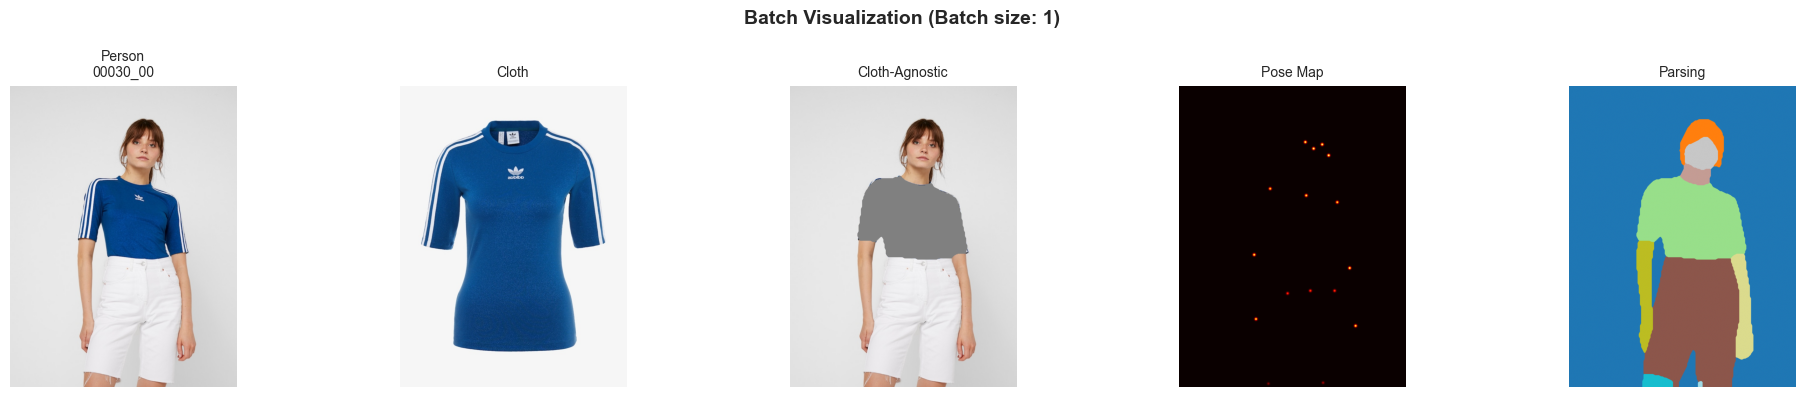

✅ Batch visualization saved (showing 1 sample(s))


In [10]:
def denormalize(tensor: torch.Tensor) -> torch.Tensor:
    """Denormalize from [-1, 1] to [0, 1]."""
    return tensor * 0.5 + 0.5


# Visualize batch - dynamically handle any batch size
actual_batch_size = batch['person_image'].size(0)
num_samples = min(4, actual_batch_size)  # Show up to 4 samples

fig, axes = plt.subplots(num_samples, 5, figsize=(20, num_samples * 4))

# Handle single sample case (need to reshape axes)
if num_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(num_samples):
    # Person image
    person = denormalize(batch['person_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(np.clip(person, 0, 1))
    axes[i, 0].set_title(f"Person\n{batch['id'][i]}" if i == 0 else batch['id'][i], fontsize=10)
    axes[i, 0].axis('off')
    
    # Cloth image
    cloth = denormalize(batch['cloth_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(np.clip(cloth, 0, 1))
    axes[i, 1].set_title('Cloth' if i == 0 else '', fontsize=10)
    axes[i, 1].axis('off')
    
    # Cloth-agnostic
    ca = denormalize(batch['cloth_agnostic'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 2].imshow(np.clip(ca, 0, 1))
    axes[i, 2].set_title('Cloth-Agnostic' if i == 0 else '', fontsize=10)
    axes[i, 2].axis('off')
    
    # Pose map (max across channels)
    pose = torch.max(batch['pose_map'][i], dim=0)[0].cpu().numpy()
    axes[i, 3].imshow(pose, cmap='hot')
    axes[i, 3].set_title('Pose Map' if i == 0 else '', fontsize=10)
    axes[i, 3].axis('off')
    
    # Parsing (argmax to get class labels)
    parsing = torch.argmax(batch['parsing_onehot'][i], dim=0).cpu().numpy()
    axes[i, 4].imshow(parsing, cmap='tab20')
    axes[i, 4].set_title('Parsing' if i == 0 else '', fontsize=10)
    axes[i, 4].axis('off')

plt.suptitle(f'Batch Visualization (Batch size: {actual_batch_size})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'batch_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Batch visualization saved (showing {num_samples} sample(s))")

## 10. Timing Benchmark

In [10]:
print("="*70)
print("⏱️ DATALOADER TIMING BENCHMARK")
print("="*70)

# Benchmark loading speed
n_batches = 20
times = []

print(f"\n🔄 Loading {n_batches} batches...\n")

for i, batch in enumerate(tqdm(train_loader, total=n_batches, desc="Timing")):
    start = time.time()
    
    # Simulate moving to GPU
    if torch.cuda.is_available():
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].to(device)
    
    times.append(time.time() - start)
    
    if i >= n_batches - 1:
        break

times = np.array(times)

print(f"\n📊 Timing Statistics:")
print("-" * 50)
print(f"   Mean time per batch: {times.mean()*1000:.2f} ms")
print(f"   Std time per batch: {times.std()*1000:.2f} ms")
print(f"   Min time per batch: {times.min()*1000:.2f} ms")
print(f"   Max time per batch: {times.max()*1000:.2f} ms")

# Calculate samples per second
samples_per_second = batch_size / times.mean()
print(f"\n⚡ Throughput: {samples_per_second:.2f} samples/second")

# Estimate epoch time
epoch_time = len(train_loader) * times.mean() / 60  # minutes
print(f"📊 Estimated epoch time: {epoch_time:.2f} minutes")

print("\n" + "="*70)
print("\n✅ Timing benchmark complete!")

⏱️ DATALOADER TIMING BENCHMARK

🔄 Loading 20 batches...



Timing:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Timing Statistics:
--------------------------------------------------
   Mean time per batch: 306.63 ms
   Std time per batch: 73.90 ms
   Min time per batch: 120.25 ms
   Max time per batch: 396.03 ms

⚡ Throughput: 13.04 samples/second
📊 Estimated epoch time: 13.39 minutes


✅ Timing benchmark complete!


## 11. Memory Analysis

In [11]:
print("="*70)
print("💾 MEMORY ANALYSIS")
print("="*70)

# Single sample memory
sample = train_dataset[0]
sample_memory = 0

print(f"\n📊 Single Sample Memory:")
print("-" * 50)
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2
        sample_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {sample_memory:.2f} MB")

# Batch memory
batch = next(iter(train_loader))
batch_memory = 0

print(f"\n📊 Batch Memory (batch_size={batch_size}):")
print("-" * 50)
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2
        batch_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {batch_memory:.2f} MB")

# GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    # Move batch to GPU
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device)
    
    gpu_memory = torch.cuda.memory_allocated() / 1024**2
    gpu_reserved = torch.cuda.memory_reserved() / 1024**2
    
    print(f"\n📊 GPU Memory:")
    print("-" * 50)
    print(f"   Allocated: {gpu_memory:.2f} MB")
    print(f"   Reserved: {gpu_reserved:.2f} MB")
    print(f"   Total GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")

print("\n" + "="*70)
print("\n✅ Memory analysis complete!")

💾 MEMORY ANALYSIS

📊 Single Sample Memory:
--------------------------------------------------
   person_image             : 9.00 MB
   cloth_image              : 9.00 MB
   cloth_agnostic           : 9.00 MB
   pose_map                 : 54.00 MB
   parsing_onehot           : 60.00 MB
   ca_mask                  : 3.00 MB
   Total                    : 144.00 MB

📊 Batch Memory (batch_size=4):
--------------------------------------------------
   person_image             : 36.00 MB
   cloth_image              : 36.00 MB
   cloth_agnostic           : 36.00 MB
   pose_map                 : 216.00 MB
   parsing_onehot           : 240.00 MB
   ca_mask                  : 12.00 MB
   Total                    : 576.00 MB

📊 GPU Memory:
--------------------------------------------------
   Allocated: 576.00 MB
   Reserved: 576.00 MB
   Total GPU: 2047.75 MB


✅ Memory analysis complete!


## 12. Save Dataset Configuration

In [12]:
# Create dataset configuration
dataset_config = {
    'dataset': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'total_samples': len(train_dataset) + len(val_dataset) + len(test_dataset)
    },
    'dataloader': {
        'batch_size': batch_size,
        'num_workers': 0,
        'pin_memory': torch.cuda.is_available(),
        'train_batches': len(train_loader),
        'val_batches': len(val_loader),
        'test_batches': len(test_loader)
    },
    'data_format': {
        'image_size': list(train_dataset.image_size),
        'channels': {
            'person_image': 3,
            'cloth_image': 3,
            'cloth_agnostic': 3,
            'pose_map': 18,
            'parsing_onehot': 20,
            'ca_mask': 1,
            'total_input': 41
        },
        'normalization': {
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'range': [-1, 1]
        }
    },
    'augmentation': {
        'horizontal_flip_prob': 0.5,
        'color_jitter_prob': 0.3
    },
    'performance': {
        'mean_batch_time_ms': float(times.mean() * 1000),
        'throughput_samples_per_sec': float(samples_per_second),
        'estimated_epoch_time_min': float(epoch_time),
        'single_sample_memory_mb': float(sample_memory),
        'batch_memory_mb': float(batch_memory)
    }
}

# Save configuration
config_path = output_dir / 'dataset_config.json'
with open(config_path, 'w') as f:
    json.dump(dataset_config, f, indent=2)

print("="*70)
print("💾 DATASET CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - Total samples: {dataset_config['dataset']['total_samples']:,}")
print(f"   - Batch size: {dataset_config['dataloader']['batch_size']}")
print(f"   - Input channels: {dataset_config['data_format']['channels']['total_input']}")
print(f"   - Throughput: {dataset_config['performance']['throughput_samples_per_sec']:.2f} samples/sec")
print(f"   - Epoch time: {dataset_config['performance']['estimated_epoch_time_min']:.2f} min")

print("\n" + "="*70)

💾 DATASET CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\dataset\dataset_config.json

📊 Summary:
   - Total samples: 13,679
   - Batch size: 4
   - Input channels: 41
   - Throughput: 13.04 samples/sec
   - Epoch time: 13.39 min



## 13. Summary

In [13]:
print("="*70)
print("🎉 PYTORCH DATASET & DATALOADER COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Implemented VITONDataset class")
print("   2. ✓ Created data augmentation pipeline")
print("   3. ✓ Built training, validation, and test DataLoaders")
print("   4. ✓ Tested single sample and batch loading")
print("   5. ✓ Benchmarked loading performance")
print("   6. ✓ Analyzed memory usage")
print("   7. ✓ Saved dataset configuration")

print(f"\n📊 Key Metrics:")
print(f"   - Train samples: {len(train_dataset):,}")
print(f"   - Val samples: {len(val_dataset):,}")
print(f"   - Test samples: {len(test_dataset):,}")
print(f"   - Batch size: {batch_size}")
print(f"   - Input channels: 41 (3 + 18 + 20)")
print(f"   - Throughput: {samples_per_second:.2f} samples/sec")
print(f"   - Epoch time: {epoch_time:.2f} minutes")

print(f"\n📁 Generated Files:")
print(f"   - batch_visualization.png")
print(f"   - dataset_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Begin model architecture development")
print("   2. Implement Generator network")
print("   3. Implement Discriminator network")
print("   4. Create training loop with losses")
print("   5. Start model training")

print("\n💡 Key Components Created:")
print("   - VITONDataset: Complete PyTorch Dataset")
print("     * Load all modalities (person, cloth, parsing, pose)")
print("     * Generate cloth-agnostic representation")
print("     * Create multi-channel input (41 channels)")
print("     * Support data augmentation")
print("   - VITONAugmentation: Synchronized augmentation")
print("     * Horizontal flip (50% probability)")
print("     * Color jitter (30% probability)")
print("   - DataLoaders: Optimized batch loading")
print("     * Windows compatible (num_workers=0)")
print("     * GPU memory pinning enabled")
print("     * Efficient batch processing")

print("\n" + "="*70)

print("\n✅ DATASET MODULE READY FOR TRAINING!")
print("="*70)

🎉 PYTORCH DATASET & DATALOADER COMPLETE!

✅ Completed Tasks:
   1. ✓ Implemented VITONDataset class
   2. ✓ Created data augmentation pipeline
   3. ✓ Built training, validation, and test DataLoaders
   4. ✓ Tested single sample and batch loading
   5. ✓ Benchmarked loading performance
   6. ✓ Analyzed memory usage
   7. ✓ Saved dataset configuration

📊 Key Metrics:
   - Train samples: 10,482
   - Val samples: 1,165
   - Test samples: 2,032
   - Batch size: 4
   - Input channels: 41 (3 + 18 + 20)
   - Throughput: 13.04 samples/sec
   - Epoch time: 13.39 minutes

📁 Generated Files:
   - batch_visualization.png
   - dataset_config.json

🚀 Ready for Next Steps:
   1. Begin model architecture development
   2. Implement Generator network
   3. Implement Discriminator network
   4. Create training loop with losses
   5. Start model training

💡 Key Components Created:
   - VITONDataset: Complete PyTorch Dataset
     * Load all modalities (person, cloth, parsing, pose)
     * Generate cloth-a

# Model Architecture


In [14]:
# Ensure `torchsummary` is installed and importable (fallback to `torchinfo`)
import importlib, subprocess, sys


def ensure_package(pkg_name: str, import_name: str = None):
    name = import_name or pkg_name
    try:
        return importlib.import_module(name)
    except Exception:
        print(f"⚠️ {name} not found — installing {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
        importlib.invalidate_caches()
        module = importlib.import_module(name)
        print(f"✅ Installed and imported {name}")
        return module

# Primary: torchsummary
try:
    ts = ensure_package("torchsummary", "torchsummary")
    from torchsummary import summary
    print("✅ `torchsummary.summary` is available")
except Exception as e:
    print("⚠️ Failed to import `torchsummary` (will try fallback):", e)
    # Fallback: torchinfo
    try:
        ti = ensure_package("torchinfo", "torchinfo")
        from torchinfo import summary
        print("✅ Using fallback `torchinfo.summary`")
    except Exception as e2:
        print("❌ Failed to install fallback 'torchinfo':", e2)
        print("Please install `torchsummary` or `torchinfo` in your environment and re-run this cell.")

✅ `torchsummary.summary` is available


## 1. Import Libraries

In [15]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torchsummary import summary

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Configuration

In [16]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
output_dir = project_root / 'outputs' / 'model_architecture'
output_dir.mkdir(parents=True, exist_ok=True)

# Load dataset configuration
with open(project_root / 'outputs' / 'dataset' / 'dataset_config.json', 'r') as f:
    dataset_config = json.load(f)

print(f"📁 Project Root: {project_root}")
print(f"📁 Output Directory: {output_dir}")
print(f"\n✅ Loaded dataset configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Model configuration
model_config = {
    'input_channels': 41,  # 3 CA + 18 Pose + 20 Parsing
    'output_channels': 3,  # RGB
    'image_size': (1024, 768),
    'ngf': 64,  # Generator base channels
    'ndf': 64,  # Discriminator base channels
    'n_downsampling': 4,
    'n_blocks': 9,  # Residual blocks at bottleneck
    'use_dropout': True,
    'use_attention': True
}

print(f"\n📊 Model Configuration:")
for key, value in model_config.items():
    print(f"   {key}: {value}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\model_architecture

✅ Loaded dataset configuration

🖥️ Using device: cuda

📊 Model Configuration:
   input_channels: 41
   output_channels: 3
   image_size: (1024, 768)
   ngf: 64
   ndf: 64
   n_downsampling: 4
   n_blocks: 9
   use_dropout: True
   use_attention: True


## 3. Building Blocks

Define reusable components for the networks.

In [17]:
class ResidualBlock(nn.Module):
    """
    Residual block with two convolutional layers.
    """
    def __init__(self, channels: int, use_dropout: bool = False):
        super().__init__()
        
        layers = [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True)
        ]
        
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        
        layers += [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        ]
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)


class SelfAttention(nn.Module):
    """
    Self-attention module for capturing long-range dependencies.
    """
    def __init__(self, channels: int):
        super().__init__()
        
        self.query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, channels, height, width = x.size()
        
        # Query, Key, Value
        q = self.query(x).view(batch, -1, height * width).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, height * width)
        v = self.value(x).view(batch, -1, height * width)
        
        # Attention map
        attention = F.softmax(torch.bmm(q, k), dim=-1)
        
        # Apply attention
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        
        return self.gamma * out + x


class DownsampleBlock(nn.Module):
    """
    Downsampling block for encoder.
    """
    def __init__(self, in_channels: int, out_channels: int, 
                 normalize: bool = True, dropout: float = 0.0):
        super().__init__()
        
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, 
                     stride=2, padding=1, bias=False)
        ]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UpsampleBlock(nn.Module):
    """
    Upsampling block for decoder with skip connections.
    """
    def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.0):
        super().__init__()
        
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, skip: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.block(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        return x


print("✅ Building blocks defined:")
print("   - ResidualBlock")
print("   - SelfAttention")
print("   - DownsampleBlock")
print("   - UpsampleBlock")

✅ Building blocks defined:
   - ResidualBlock
   - SelfAttention
   - DownsampleBlock
   - UpsampleBlock


## 4. Generator Network

U-Net architecture with attention and residual connections.

In [18]:
class Generator(nn.Module):
    """
    U-Net based Generator for Virtual Try-On.
    
    Input: [B, 41, H, W] (cloth-agnostic + pose + parsing)
    Output: [B, 3, H, W] (RGB image)
    """
    
    def __init__(self, 
                 in_channels: int = 41,
                 out_channels: int = 3,
                 ngf: int = 64,
                 n_downsampling: int = 4,
                 n_blocks: int = 9,
                 use_dropout: bool = True,
                 use_attention: bool = True):
        super().__init__()
        
        self.n_downsampling = n_downsampling
        
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, ngf, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        )
        
        # Encoder (downsampling)
        self.encoder = nn.ModuleList()
        mult = 1
        for i in range(n_downsampling):
            mult_prev = mult
            mult = min(2 ** (i + 1), 8)
            self.encoder.append(
                DownsampleBlock(
                    ngf * mult_prev,
                    ngf * mult,
                    normalize=True,
                    dropout=0.0
                )
            )
        
        # Bottleneck (residual blocks)
        bottleneck_channels = ngf * mult
        self.bottleneck = nn.ModuleList()
        for _ in range(n_blocks):
            self.bottleneck.append(
                ResidualBlock(bottleneck_channels, use_dropout=use_dropout)
            )
        
        # Self-attention at bottleneck
        self.attention = SelfAttention(bottleneck_channels) if use_attention else None
        
        # Decoder (upsampling)
        self.decoder = nn.ModuleList()
        for i in range(n_downsampling):
            mult_prev = min(2 ** (n_downsampling - i), 8)
            mult = min(2 ** (n_downsampling - i - 1), 8)
            
            # Account for skip connections (double the input channels)
            in_ch = ngf * mult_prev
            out_ch = ngf * mult
            
            self.decoder.append(
                UpsampleBlock(
                    in_ch * 2,  # *2 for skip connection
                    out_ch,
                    dropout=0.5 if i < 3 and use_dropout else 0.0
                )
            )
        
        # Final convolution
        self.final = nn.Sequential(
            nn.Conv2d(ngf * 2, ngf, kernel_size=3, padding=1, bias=False),  # *2 for skip
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf, out_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through Generator.
        
        Args:
            x: Input tensor [B, 41, H, W]
        
        Returns:
            Generated image [B, 3, H, W]
        """
        # Initial convolution
        x = self.initial(x)
        
        # Encoder with skip connections
        skip_connections = [x]
        for encoder_block in self.encoder:
            x = encoder_block(x)
            skip_connections.append(x)
        
        # Bottleneck
        for res_block in self.bottleneck:
            x = res_block(x)
        
        # Attention
        if self.attention is not None:
            x = self.attention(x)
        
        # Decoder with skip connections
        skip_connections = skip_connections[::-1]  # Reverse order
        for i, decoder_block in enumerate(self.decoder):
            skip = skip_connections[i]
            x = torch.cat([x, skip], dim=1)
            x = decoder_block(x)
        
        # Final convolution with last skip connection
        x = torch.cat([x, skip_connections[-1]], dim=1)
        x = self.final(x)
        
        return x


print("✅ Generator network defined")
print("   Architecture: U-Net with attention")
print("   Input: [B, 41, H, W]")
print("   Output: [B, 3, H, W]")

✅ Generator network defined
   Architecture: U-Net with attention
   Input: [B, 41, H, W]
   Output: [B, 3, H, W]


## 5. Discriminator Network

PatchGAN discriminator with spectral normalization.

In [19]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator for Virtual Try-On.
    
    Classifies 70x70 patches as real or fake.
    Uses spectral normalization for training stability.
    """
    
    def __init__(self,
                 in_channels: int = 6,  # 3 (image) + 3 (condition)
                 ndf: int = 64,
                 n_layers: int = 3,
                 use_spectral_norm: bool = True):
        super().__init__()
        
        norm_layer = spectral_norm if use_spectral_norm else lambda x: x
        
        # Initial layer (no normalization)
        layers = [
            norm_layer(nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate layers
        mult = 1
        for n in range(1, n_layers):
            mult_prev = mult
            mult = min(2 ** n, 8)
            layers += [
                norm_layer(nn.Conv2d(ndf * mult_prev, ndf * mult, 
                                    kernel_size=4, stride=2, padding=1, bias=False)),
                nn.InstanceNorm2d(ndf * mult),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final layers
        mult_prev = mult
        mult = min(2 ** n_layers, 8)
        layers += [
            norm_layer(nn.Conv2d(ndf * mult_prev, ndf * mult,
                                kernel_size=4, stride=1, padding=1, bias=False)),
            nn.InstanceNorm2d(ndf * mult),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Output layer
        layers.append(
            norm_layer(nn.Conv2d(ndf * mult, 1, kernel_size=4, stride=1, padding=1))
        )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through Discriminator.
        
        Args:
            x: Input image [B, 3, H, W]
            condition: Condition image [B, 3, H, W] (e.g., cloth-agnostic)
        
        Returns:
            Patch predictions [B, 1, H', W']
        """
        # Concatenate image and condition
        x = torch.cat([x, condition], dim=1)
        return self.model(x)


print("✅ Discriminator network defined")
print("   Architecture: PatchGAN with spectral normalization")
print("   Input: [B, 6, H, W] (image + condition)")
print("   Output: [B, 1, H', W'] (patch predictions)")

✅ Discriminator network defined
   Architecture: PatchGAN with spectral normalization
   Input: [B, 6, H, W] (image + condition)
   Output: [B, 1, H', W'] (patch predictions)


## 6. Initialize Models

In [20]:
# Initialize Generator
generator = Generator(
    in_channels=model_config['input_channels'],
    out_channels=model_config['output_channels'],
    ngf=model_config['ngf'],
    n_downsampling=model_config['n_downsampling'],
    n_blocks=model_config['n_blocks'],
    use_dropout=model_config['use_dropout'],
    use_attention=model_config['use_attention']
).to(device)

# Initialize Discriminator
discriminator = Discriminator(
    in_channels=6,  # RGB image + RGB condition
    ndf=model_config['ndf'],
    n_layers=3,
    use_spectral_norm=True
).to(device)

print("="*70)
print("🎯 MODELS INITIALIZED")
print("="*70)
print(f"\n✅ Generator created and moved to {device}")
print(f"✅ Discriminator created and moved to {device}")

🎯 MODELS INITIALIZED

✅ Generator created and moved to cuda
✅ Discriminator created and moved to cuda


## 7. Count Parameters

In [21]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
    """
    Count total and trainable parameters.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


# Count parameters
gen_total, gen_trainable = count_parameters(generator)
disc_total, disc_trainable = count_parameters(discriminator)

print("="*70)
print("📊 PARAMETER COUNT")
print("="*70)

print(f"\n🔷 Generator:")
print(f"   Total parameters: {gen_total:,}")
print(f"   Trainable parameters: {gen_trainable:,}")
print(f"   Memory: {gen_total * 4 / 1024**2:.2f} MB (float32)")

print(f"\n🔶 Discriminator:")
print(f"   Total parameters: {disc_total:,}")
print(f"   Trainable parameters: {disc_trainable:,}")
print(f"   Memory: {disc_total * 4 / 1024**2:.2f} MB (float32)")

print(f"\n📊 Total:")
print(f"   Combined parameters: {gen_total + disc_total:,}")
print(f"   Combined memory: {(gen_total + disc_total) * 4 / 1024**2:.2f} MB")

print("\n" + "="*70)

📊 PARAMETER COUNT

🔷 Generator:
   Total parameters: 63,847,812
   Trainable parameters: 63,847,812
   Memory: 243.56 MB (float32)

🔶 Discriminator:
   Total parameters: 2,766,913
   Trainable parameters: 2,766,913
   Memory: 10.55 MB (float32)

📊 Total:
   Combined parameters: 66,614,725
   Combined memory: 254.12 MB



## 8. Test Forward Pass - Generator

In [22]:
print("="*70)
print("🧪 TESTING GENERATOR FORWARD PASS")
print("="*70)

# Create dummy input
batch_size = 2
dummy_input = torch.randn(batch_size, 41, 1024, 768).to(device)

print(f"\n📥 Input shape: {tuple(dummy_input.shape)}")
print(f"   Channels breakdown:")
print(f"   - Cloth-agnostic RGB: 3")
print(f"   - Pose heatmaps: 18")
print(f"   - Parsing one-hot: 20")
print(f"   Total: 41 channels")

# Forward pass
generator.eval()
with torch.no_grad():
    output = generator(dummy_input)

print(f"\n📤 Output shape: {tuple(output.shape)}")
print(f"   Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")
print(f"   Expected range: [-1, 1] (Tanh activation)")

# Check output
assert output.shape == (batch_size, 3, 1024, 768), "Output shape mismatch!"
assert output.min() >= -1.0 and output.max() <= 1.0, "Output range incorrect!"

print(f"\n✅ Generator forward pass successful!")
print(f"   Input: {tuple(dummy_input.shape)}")
print(f"   Output: {tuple(output.shape)}")

# Memory usage
if torch.cuda.is_available():
    mem_allocated = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"\n💾 GPU Memory:")
    print(f"   Allocated: {mem_allocated:.2f} MB")
    print(f"   Reserved: {mem_reserved:.2f} MB")

print("\n" + "="*70)

🧪 TESTING GENERATOR FORWARD PASS

📥 Input shape: (2, 41, 1024, 768)
   Channels breakdown:
   - Cloth-agnostic RGB: 3
   - Pose heatmaps: 18
   - Parsing one-hot: 20
   Total: 41 channels

📤 Output shape: (2, 3, 1024, 768)
   Output range: [-0.960, 0.915]
   Expected range: [-1, 1] (Tanh activation)

✅ Generator forward pass successful!
   Input: (2, 41, 1024, 768)
   Output: (2, 3, 1024, 768)

💾 GPU Memory:
   Allocated: 1103.31 MB
   Reserved: 4834.00 MB



## 9. Test Forward Pass - Discriminator

In [23]:
print("="*70)
print("🧪 TESTING DISCRIMINATOR FORWARD PASS")
print("="*70)

# Create dummy inputs
dummy_image = torch.randn(batch_size, 3, 1024, 768).to(device)
dummy_condition = torch.randn(batch_size, 3, 1024, 768).to(device)

print(f"\n📥 Input shapes:")
print(f"   Image: {tuple(dummy_image.shape)}")
print(f"   Condition: {tuple(dummy_condition.shape)}")

# Forward pass
discriminator.eval()
with torch.no_grad():
    disc_output = discriminator(dummy_image, dummy_condition)

print(f"\n📤 Output shape: {tuple(disc_output.shape)}")
print(f"   Output range: [{disc_output.min().item():.3f}, {disc_output.max().item():.3f}]")

# Calculate receptive field size
patch_h, patch_w = disc_output.shape[2], disc_output.shape[3]
print(f"\n📊 Patch predictions:")
print(f"   Number of patches: {patch_h} × {patch_w} = {patch_h * patch_w}")
print(f"   Each patch covers ~70×70 pixels")

print(f"\n✅ Discriminator forward pass successful!")
print(f"   Image: {tuple(dummy_image.shape)}")
print(f"   Condition: {tuple(dummy_condition.shape)}")
print(f"   Output: {tuple(disc_output.shape)}")

print("\n" + "="*70)

🧪 TESTING DISCRIMINATOR FORWARD PASS

📥 Input shapes:
   Image: (2, 3, 1024, 768)
   Condition: (2, 3, 1024, 768)

📤 Output shape: (2, 1, 126, 94)
   Output range: [-1043.094, 820.921]

📊 Patch predictions:
   Number of patches: 126 × 94 = 11844
   Each patch covers ~70×70 pixels

✅ Discriminator forward pass successful!
   Image: (2, 3, 1024, 768)
   Condition: (2, 3, 1024, 768)
   Output: (2, 1, 126, 94)



## 10. Test Full Pipeline

In [24]:
print("="*70)
print("🔄 TESTING FULL PIPELINE")
print("="*70)

# Create dummy input
print("\n📥 Creating dummy inputs...")
multi_channel_input = torch.randn(batch_size, 41, 1024, 768).to(device)
real_image = torch.randn(batch_size, 3, 1024, 768).to(device)
condition = torch.randn(batch_size, 3, 1024, 768).to(device)

# Generator forward pass
print("\n🔷 Generator: Generating fake images...")
generator.eval()
with torch.no_grad():
    fake_image = generator(multi_channel_input)

print(f"   Input: {tuple(multi_channel_input.shape)}")
print(f"   Output (fake): {tuple(fake_image.shape)}")

# Discriminator forward pass on fake
print("\n🔶 Discriminator: Evaluating fake images...")
discriminator.eval()
with torch.no_grad():
    pred_fake = discriminator(fake_image, condition)

print(f"   Fake prediction: {tuple(pred_fake.shape)}")
print(f"   Mean score: {pred_fake.mean().item():.3f}")

# Discriminator forward pass on real
print("\n🔶 Discriminator: Evaluating real images...")
with torch.no_grad():
    pred_real = discriminator(real_image, condition)

print(f"   Real prediction: {tuple(pred_real.shape)}")
print(f"   Mean score: {pred_real.mean().item():.3f}")

print("\n✅ Full pipeline test successful!")
print("\n📊 Pipeline Summary:")
print(f"   1. Multi-channel input [{batch_size}, 41, 1024, 768]")
print(f"   2. Generator → Fake image [{batch_size}, 3, 1024, 768]")
print(f"   3. Discriminator(fake) → Patches [{batch_size}, 1, {patch_h}, {patch_w}]")
print(f"   4. Discriminator(real) → Patches [{batch_size}, 1, {patch_h}, {patch_w}]")

print("\n" + "="*70)

🔄 TESTING FULL PIPELINE

📥 Creating dummy inputs...

🔷 Generator: Generating fake images...
   Input: (2, 41, 1024, 768)
   Output (fake): (2, 3, 1024, 768)

🔶 Discriminator: Evaluating fake images...
   Fake prediction: (2, 1, 126, 94)
   Mean score: 1.938

🔶 Discriminator: Evaluating real images...
   Real prediction: (2, 1, 126, 94)
   Mean score: 1.978

✅ Full pipeline test successful!

📊 Pipeline Summary:
   1. Multi-channel input [2, 41, 1024, 768]
   2. Generator → Fake image [2, 3, 1024, 768]
   3. Discriminator(fake) → Patches [2, 1, 126, 94]
   4. Discriminator(real) → Patches [2, 1, 126, 94]



## 11. Model Architecture Visualization

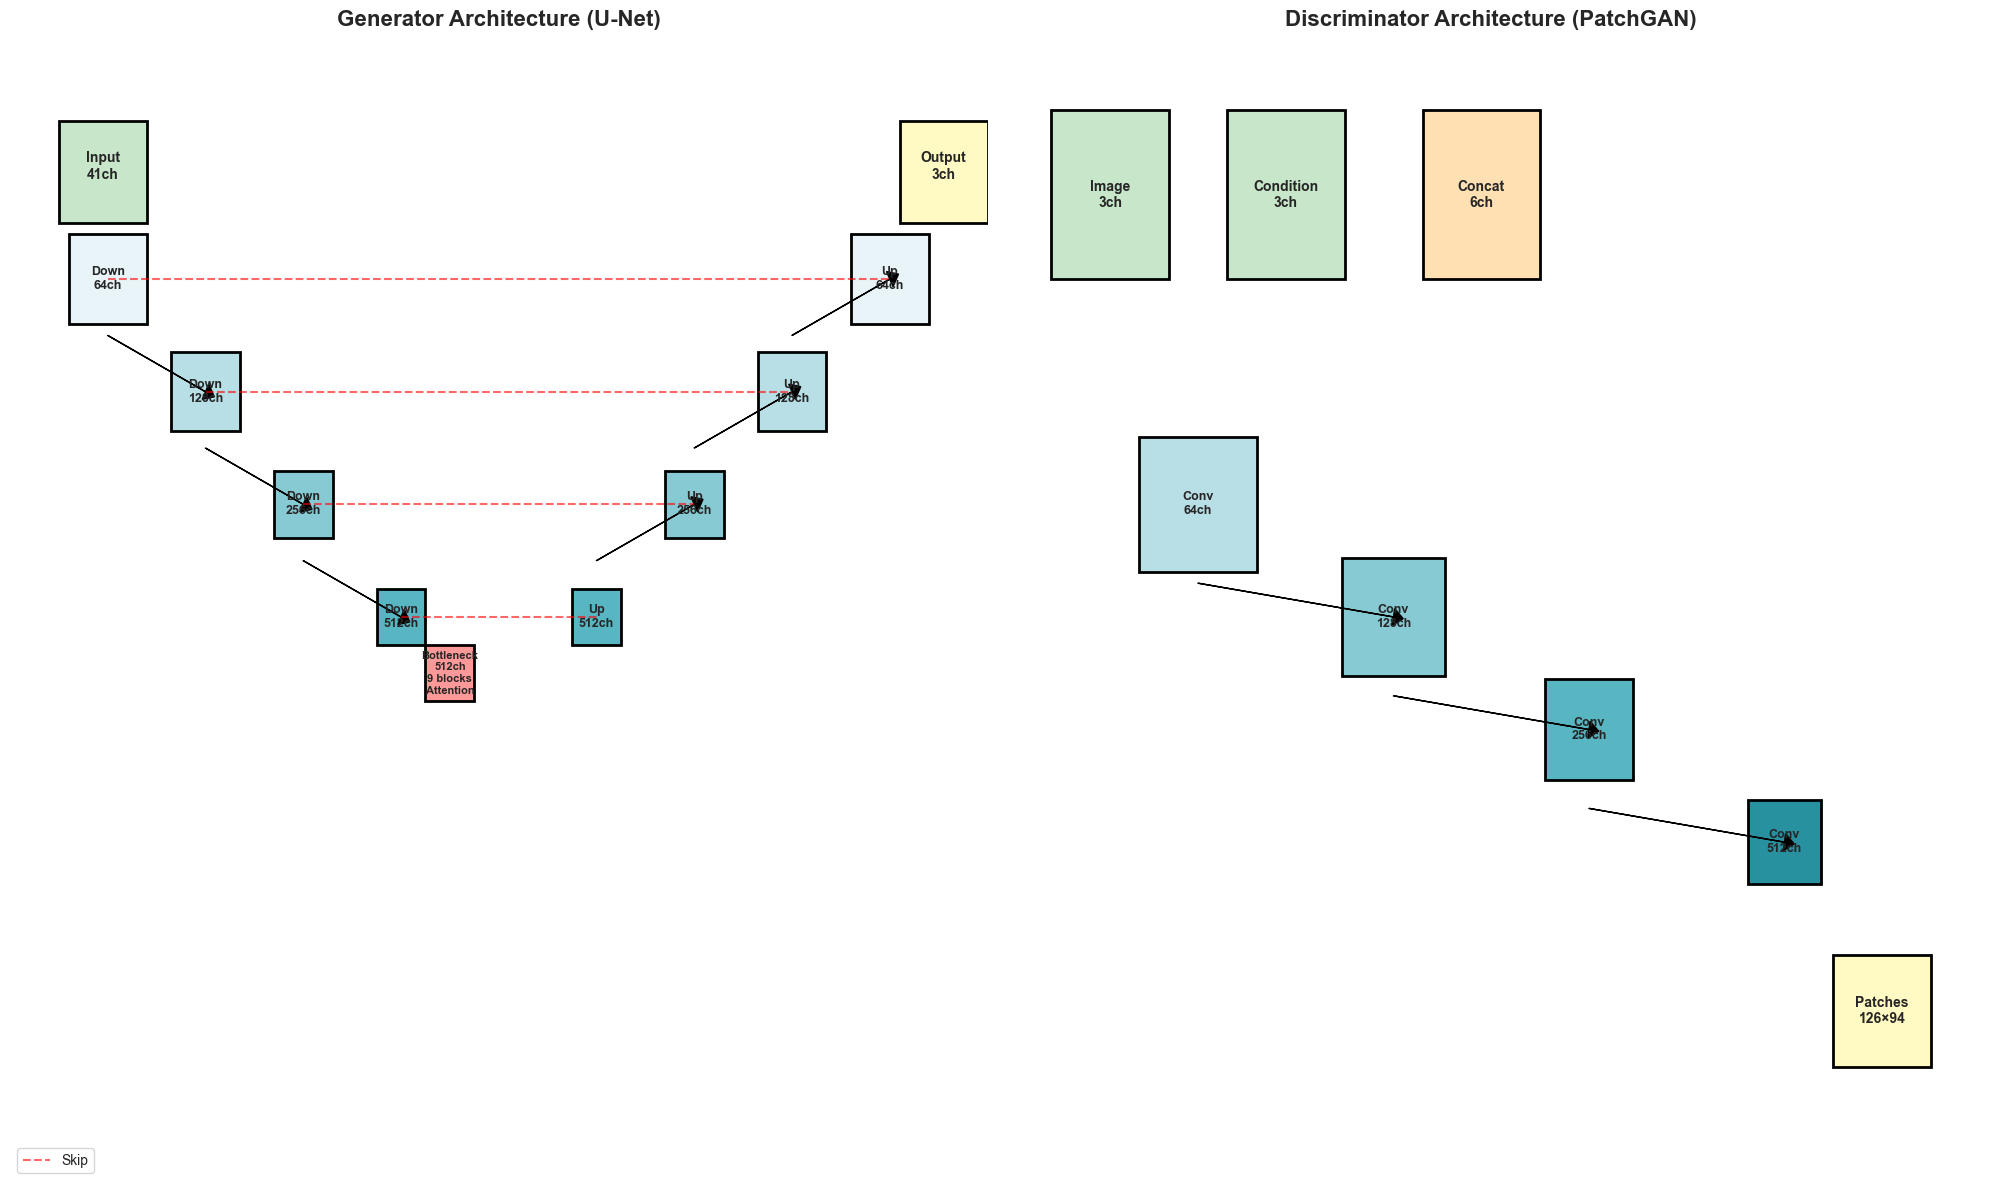

✅ Architecture visualization saved


In [25]:
def visualize_architecture():
    """
    Create visual diagram of model architecture.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    
    # Generator U-Net visualization
    ax1.set_title('Generator Architecture (U-Net)', fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    
    # Encoder path
    encoder_colors = ['#e8f4f8', '#b8dfe6', '#88cad4', '#58b5c2']
    encoder_positions = [(1, 8), (2, 7), (3, 6), (4, 5)]
    encoder_sizes = [(0.8, 0.8), (0.7, 0.7), (0.6, 0.6), (0.5, 0.5)]
    
    # Input
    ax1.add_patch(Rectangle((0.5, 8.5), 0.9, 0.9, 
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax1.text(0.95, 9.0, 'Input\n41ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Encoder blocks
    for i, (pos, size, color) in enumerate(zip(encoder_positions, encoder_sizes, encoder_colors)):
        channels = 64 * min(2**i, 8)
        ax1.add_patch(Rectangle((pos[0]-size[0]/2, pos[1]-size[1]/2), size[0], size[1],
                                facecolor=color, edgecolor='black', linewidth=2))
        ax1.text(pos[0], pos[1], f'Down\n{channels}ch', ha='center', va='center', 
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax1.arrow(encoder_positions[i-1][0], encoder_positions[i-1][1]-0.5,
                     pos[0]-encoder_positions[i-1][0], pos[1]-encoder_positions[i-1][1]+0.5,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Bottleneck
    ax1.add_patch(Rectangle((4.25, 4.25), 0.5, 0.5,
                            facecolor='#ff9999', edgecolor='black', linewidth=2))
    ax1.text(4.5, 4.5, 'Bottleneck\n512ch\n9 blocks\nAttention', 
            ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Decoder path
    decoder_positions = [(6, 5), (7, 6), (8, 7), (9, 8)]
    decoder_sizes = [(0.5, 0.5), (0.6, 0.6), (0.7, 0.7), (0.8, 0.8)]
    
    for i, (pos, size, color) in enumerate(zip(decoder_positions, decoder_sizes, 
                                               encoder_colors[::-1])):
        channels = 64 * min(2**(3-i), 8)
        ax1.add_patch(Rectangle((pos[0]-size[0]/2, pos[1]-size[1]/2), size[0], size[1],
                                facecolor=color, edgecolor='black', linewidth=2))
        ax1.text(pos[0], pos[1], f'Up\n{channels}ch', ha='center', va='center',
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax1.arrow(decoder_positions[i-1][0], decoder_positions[i-1][1]+0.5,
                     pos[0]-decoder_positions[i-1][0], pos[1]-decoder_positions[i-1][1]-0.5,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Output
    ax1.add_patch(Rectangle((9.1, 8.5), 0.9, 0.9,
                            facecolor='#fff9c4', edgecolor='black', linewidth=2))
    ax1.text(9.55, 9.0, 'Output\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Skip connections (dashed lines)
    for enc_pos, dec_pos in zip(encoder_positions, decoder_positions[::-1]):
        ax1.plot([enc_pos[0], dec_pos[0]], [enc_pos[1], dec_pos[1]],
                'r--', linewidth=1.5, alpha=0.6, label='Skip' if enc_pos == encoder_positions[0] else '')
    
    ax1.legend(loc='lower left', fontsize=10)
    
    # Discriminator visualization
    ax2.set_title('Discriminator Architecture (PatchGAN)', fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    
    # Input images
    ax2.add_patch(Rectangle((0.5, 8), 1.2, 1.5,
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax2.text(1.1, 8.75, 'Image\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    ax2.add_patch(Rectangle((2.3, 8), 1.2, 1.5,
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax2.text(2.9, 8.75, 'Condition\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Concatenate
    ax2.add_patch(Rectangle((4.3, 8), 1.2, 1.5,
                            facecolor='#ffe0b2', edgecolor='black', linewidth=2))
    ax2.text(4.9, 8.75, 'Concat\n6ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Conv layers
    disc_colors = ['#b8dfe6', '#88cad4', '#58b5c2', '#2891a0']
    disc_positions = [(2, 6), (4, 5), (6, 4), (8, 3)]
    disc_channels = [64, 128, 256, 512]
    
    for i, (pos, color, ch) in enumerate(zip(disc_positions, disc_colors, disc_channels)):
        size = 1.2 - i * 0.15
        ax2.add_patch(Rectangle((pos[0]-size/2, pos[1]-size/2), size, size,
                                facecolor=color, edgecolor='black', linewidth=2))
        ax2.text(pos[0], pos[1], f'Conv\n{ch}ch', ha='center', va='center',
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax2.arrow(disc_positions[i-1][0], disc_positions[i-1][1]-0.7,
                     pos[0]-disc_positions[i-1][0], pos[1]-disc_positions[i-1][1]+0.7,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Output
    ax2.add_patch(Rectangle((8.5, 1), 1.0, 1.0,
                            facecolor='#fff9c4', edgecolor='black', linewidth=2))
    ax2.text(9.0, 1.5, f'Patches\n{patch_h}×{patch_w}', 
            ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'model_architecture.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Architecture visualization saved")


visualize_architecture()

## 12. Save Model Configuration

In [26]:
# Create detailed model configuration
architecture_config = {
    'generator': {
        'type': 'U-Net',
        'input_channels': model_config['input_channels'],
        'output_channels': model_config['output_channels'],
        'base_channels': model_config['ngf'],
        'n_downsampling': model_config['n_downsampling'],
        'n_blocks': model_config['n_blocks'],
        'use_dropout': model_config['use_dropout'],
        'use_attention': model_config['use_attention'],
        'total_parameters': gen_total,
        'trainable_parameters': gen_trainable,
        'memory_mb': gen_total * 4 / 1024**2
    },
    'discriminator': {
        'type': 'PatchGAN',
        'input_channels': 6,
        'base_channels': model_config['ndf'],
        'n_layers': 3,
        'use_spectral_norm': True,
        'patch_size': '70x70',
        'output_patches': f'{patch_h}x{patch_w}',
        'total_parameters': disc_total,
        'trainable_parameters': disc_trainable,
        'memory_mb': disc_total * 4 / 1024**2
    },
    'total': {
        'combined_parameters': gen_total + disc_total,
        'combined_memory_mb': (gen_total + disc_total) * 4 / 1024**2
    },
    'image_size': model_config['image_size'],
    'device': device
}

# Save configuration
config_path = output_dir / 'model_architecture_config.json'
with open(config_path, 'w') as f:
    json.dump(architecture_config, f, indent=2)

print("="*70)
print("💾 MODEL CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - Generator parameters: {gen_total:,}")
print(f"   - Discriminator parameters: {disc_total:,}")
print(f"   - Total parameters: {gen_total + disc_total:,}")
print(f"   - Total memory: {(gen_total + disc_total) * 4 / 1024**2:.2f} MB")

print("\n" + "="*70)

💾 MODEL CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\model_architecture\model_architecture_config.json

📊 Summary:
   - Generator parameters: 63,847,812
   - Discriminator parameters: 2,766,913
   - Total parameters: 66,614,725
   - Total memory: 254.12 MB



## 13. Summary

In [27]:
print("="*70)
print("🎉 MODEL ARCHITECTURE COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Implemented building blocks (ResidualBlock, Attention, etc.)")
print("   2. ✓ Created Generator (U-Net with attention)")
print("   3. ✓ Created Discriminator (PatchGAN with spectral norm)")
print("   4. ✓ Initialized both models on GPU")
print("   5. ✓ Counted parameters and memory")
print("   6. ✓ Tested Generator forward pass")
print("   7. ✓ Tested Discriminator forward pass")
print("   8. ✓ Tested full pipeline")
print("   9. ✓ Visualized architecture")
print("   10. ✓ Saved model configuration")

print(f"\n📊 Model Statistics:")
print(f"   🔷 Generator:")
print(f"      - Architecture: U-Net with self-attention")
print(f"      - Input: [B, 41, 1024, 768]")
print(f"      - Output: [B, 3, 1024, 768]")
print(f"      - Parameters: {gen_total:,}")
print(f"      - Memory: {gen_total * 4 / 1024**2:.2f} MB")
print(f"   🔶 Discriminator:")
print(f"      - Architecture: PatchGAN with spectral normalization")
print(f"      - Input: [B, 6, 1024, 768] (image + condition)")
print(f"      - Output: [B, 1, {patch_h}, {patch_w}] (patch predictions)")
print(f"      - Parameters: {disc_total:,}")
print(f"      - Memory: {disc_total * 4 / 1024**2:.2f} MB")

print(f"\n📁 Generated Files:")
print(f"   - model_architecture.png")
print(f"   - model_architecture_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Define loss functions (GAN, Perceptual, L1)")
print("   2. Implement training loop")
print("   3. Add checkpointing and logging")
print("   4. Start model training")

print("\n💡 Key Features:")
print("   - U-Net encoder-decoder architecture")
print("   - Skip connections for feature preservation")
print("   - Self-attention at bottleneck")
print("   - Residual blocks for stability")
print("   - PatchGAN discriminator (70×70)")
print("   - Spectral normalization for training stability")
print("   - Instance normalization throughout")

print("\n" + "="*70)

print("\n✅ MODEL ARCHITECTURE READY FOR TRAINING!")
print("="*70)

🎉 MODEL ARCHITECTURE COMPLETE!

✅ Completed Tasks:
   1. ✓ Implemented building blocks (ResidualBlock, Attention, etc.)
   2. ✓ Created Generator (U-Net with attention)
   3. ✓ Created Discriminator (PatchGAN with spectral norm)
   4. ✓ Initialized both models on GPU
   5. ✓ Counted parameters and memory
   6. ✓ Tested Generator forward pass
   7. ✓ Tested Discriminator forward pass
   8. ✓ Tested full pipeline
   9. ✓ Visualized architecture
   10. ✓ Saved model configuration

📊 Model Statistics:
   🔷 Generator:
      - Architecture: U-Net with self-attention
      - Input: [B, 41, 1024, 768]
      - Output: [B, 3, 1024, 768]
      - Parameters: 63,847,812
      - Memory: 243.56 MB
   🔶 Discriminator:
      - Architecture: PatchGAN with spectral normalization
      - Input: [B, 6, 1024, 768] (image + condition)
      - Output: [B, 1, 126, 94] (patch predictions)
      - Parameters: 2,766,913
      - Memory: 10.55 MB

📁 Generated Files:
   - model_architecture.png
   - model_architectu

# Loss Functions


## 1. Import Libraries

In [28]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import VGG19_Weights

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Configuration

In [29]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
output_dir = project_root / 'outputs' / 'loss_functions'
output_dir.mkdir(parents=True, exist_ok=True)

# Load model configuration
with open(project_root / 'outputs' / 'model_architecture' / 'model_architecture_config.json', 'r') as f:
    model_config = json.load(f)

print(f"📁 Project Root: {project_root}")
print(f"📁 Output Directory: {output_dir}")
print(f"\n✅ Loaded model configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Loss weights configuration
loss_config = {
    'lambda_gan': 1.0,        # GAN loss weight
    'lambda_perceptual': 10.0, # Perceptual loss weight
    'lambda_l1': 10.0,        # L1 reconstruction weight
    'lambda_fm': 10.0,        # Feature matching weight
    'vgg_layers': ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
}

print(f"\n📊 Loss Configuration:")
for key, value in loss_config.items():
    print(f"   {key}: {value}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\loss_functions

✅ Loaded model configuration

🖥️ Using device: cuda

📊 Loss Configuration:
   lambda_gan: 1.0
   lambda_perceptual: 10.0
   lambda_l1: 10.0
   lambda_fm: 10.0
   vgg_layers: ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']


## 3. VGG19 Perceptual Loss Network

In [30]:
class VGGPerceptualLoss(nn.Module):
    """
    Perceptual loss using VGG19 features.
    Computes L1 distance between features from multiple layers.
    """
    
    def __init__(self, 
                 layers: List[str] = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
                 weights: Optional[List[float]] = None):
        super().__init__()
        
        # Load pretrained VGG19
        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        
        # Freeze VGG parameters
        for param in vgg.parameters():
            param.requires_grad = False
        
        # Layer mapping
        self.layer_name_mapping = {
            'relu1_1': '1',
            'relu1_2': '3',
            'relu2_1': '6',
            'relu2_2': '8',
            'relu3_1': '11',
            'relu3_2': '13',
            'relu3_3': '15',
            'relu3_4': '17',
            'relu4_1': '20',
            'relu4_2': '22',
            'relu4_3': '24',
            'relu4_4': '26',
            'relu5_1': '29',
            'relu5_2': '31',
            'relu5_3': '33',
            'relu5_4': '35',
        }
        
        # Build feature extractors
        self.features = nn.ModuleDict()
        for layer_name in layers:
            layer_idx = int(self.layer_name_mapping[layer_name])
            self.features[layer_name] = nn.Sequential(*[vgg[i] for i in range(layer_idx + 1)])
        
        # Layer weights (equal if not specified)
        self.weights = weights if weights is not None else [1.0] * len(layers)
        
        # Normalization for ImageNet
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize from [-1, 1] to ImageNet normalization.
        """
        # Convert from [-1, 1] to [0, 1]
        x = (x + 1) / 2
        # Apply ImageNet normalization
        x = (x - self.mean) / self.std
        return x
    
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Compute perceptual loss between x and y.
        
        Args:
            x: Generated image [B, 3, H, W]
            y: Target image [B, 3, H, W]
        
        Returns:
            Perceptual loss (scalar)
        """
        # Normalize inputs
        x = self.normalize(x)
        y = self.normalize(y)
        
        loss = 0.0
        
        # Extract features and compute loss
        for (layer_name, feature_extractor), weight in zip(self.features.items(), self.weights):
            x_feat = feature_extractor(x)
            y_feat = feature_extractor(y)
            
            # L1 distance between features
            loss += weight * F.l1_loss(x_feat, y_feat)
        
        return loss


print("✅ VGGPerceptualLoss defined")
print("   - Extracts features from VGG19")
print("   - Computes L1 distance across multiple layers")
print("   - Uses ImageNet pretrained weights")

✅ VGGPerceptualLoss defined
   - Extracts features from VGG19
   - Computes L1 distance across multiple layers
   - Uses ImageNet pretrained weights


## 4. GAN Loss (Adversarial Loss)

In [31]:
class GANLoss(nn.Module):
    """
    GAN loss (adversarial loss).
    Supports multiple GAN objectives: vanilla, lsgan, hinge.
    """
    
    def __init__(self, gan_mode: str = 'lsgan', target_real_label: float = 1.0, 
                 target_fake_label: float = 0.0):
        """
        Args:
            gan_mode: Type of GAN loss ('vanilla', 'lsgan', 'hinge')
            target_real_label: Label for real images
            target_fake_label: Label for fake images
        """
        super().__init__()
        self.gan_mode = gan_mode
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'hinge':
            # Hinge loss computed manually
            self.loss = None
        else:
            raise ValueError(f"Unsupported GAN mode: {gan_mode}")
    
    def get_target_tensor(self, prediction: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Create target tensor with same size as prediction.
        """
        if target_is_real:
            target = torch.ones_like(prediction) * self.real_label
        else:
            target = torch.ones_like(prediction) * self.fake_label
        return target
    
    def forward(self, prediction: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Compute GAN loss.
        
        Args:
            prediction: Discriminator output [B, 1, H, W]
            target_is_real: Whether target should be real (True) or fake (False)
        
        Returns:
            GAN loss (scalar)
        """
        if self.gan_mode == 'hinge':
            if target_is_real:
                # Discriminator loss for real: -min(0, -1 + D(x))
                loss = F.relu(1.0 - prediction).mean()
            else:
                # Discriminator loss for fake: -min(0, -1 - D(G(z)))
                loss = F.relu(1.0 + prediction).mean()
        else:
            target = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target)
        
        return loss


print("✅ GANLoss defined")
print("   - Supports vanilla, LSGAN, and hinge loss")
print("   - Handles both real and fake predictions")

✅ GANLoss defined
   - Supports vanilla, LSGAN, and hinge loss
   - Handles both real and fake predictions


## 5. Feature Matching Loss

In [32]:
class FeatureMatchingLoss(nn.Module):
    """
    Feature matching loss.
    Matches intermediate discriminator features between real and fake images.
    """
    
    def __init__(self):
        super().__init__()
    
    def forward(self, fake_features: List[torch.Tensor], 
                real_features: List[torch.Tensor]) -> torch.Tensor:
        """
        Compute feature matching loss.
        
        Args:
            fake_features: List of feature maps from discriminator (fake images)
            real_features: List of feature maps from discriminator (real images)
        
        Returns:
            Feature matching loss (scalar)
        """
        loss = 0.0
        
        for fake_feat, real_feat in zip(fake_features, real_features):
            loss += F.l1_loss(fake_feat, real_feat.detach())
        
        return loss / len(fake_features)


print("✅ FeatureMatchingLoss defined")
print("   - Matches discriminator intermediate features")
print("   - Helps stabilize GAN training")

✅ FeatureMatchingLoss defined
   - Matches discriminator intermediate features
   - Helps stabilize GAN training


## 6. Combined Loss Module

In [33]:
class VITONLoss(nn.Module):
    """
    Combined loss for Virtual Try-On.
    Combines GAN, perceptual, L1, and feature matching losses.
    """
    
    def __init__(self, 
                 lambda_gan: float = 1.0,
                 lambda_perceptual: float = 10.0,
                 lambda_l1: float = 10.0,
                 lambda_fm: float = 10.0,
                 vgg_layers: List[str] = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1'],
                 gan_mode: str = 'lsgan'):
        super().__init__()
        
        # Loss weights
        self.lambda_gan = lambda_gan
        self.lambda_perceptual = lambda_perceptual
        self.lambda_l1 = lambda_l1
        self.lambda_fm = lambda_fm
        
        # Loss functions
        self.gan_loss = GANLoss(gan_mode=gan_mode)
        self.perceptual_loss = VGGPerceptualLoss(layers=vgg_layers)
        self.l1_loss = nn.L1Loss()
        self.fm_loss = FeatureMatchingLoss()
    
    def compute_generator_loss(self,
                              fake_image: torch.Tensor,
                              real_image: torch.Tensor,
                              disc_fake: torch.Tensor,
                              fake_features: Optional[List[torch.Tensor]] = None,
                              real_features: Optional[List[torch.Tensor]] = None) -> Dict[str, torch.Tensor]:
        """
        Compute generator losses.
        
        Args:
            fake_image: Generated image [B, 3, H, W]
            real_image: Target real image [B, 3, H, W]
            disc_fake: Discriminator output for fake image [B, 1, H', W']
            fake_features: Discriminator features for fake (optional)
            real_features: Discriminator features for real (optional)
        
        Returns:
            Dictionary with individual and total losses
        """
        losses = {}
        
        # GAN loss (fool discriminator)
        losses['gan'] = self.gan_loss(disc_fake, target_is_real=True) * self.lambda_gan
        
        # Perceptual loss
        losses['perceptual'] = self.perceptual_loss(fake_image, real_image) * self.lambda_perceptual
        
        # L1 reconstruction loss
        losses['l1'] = self.l1_loss(fake_image, real_image) * self.lambda_l1
        
        # Feature matching loss (if features provided)
        if fake_features is not None and real_features is not None:
            losses['fm'] = self.fm_loss(fake_features, real_features) * self.lambda_fm
        else:
            losses['fm'] = torch.tensor(0.0, device=fake_image.device)
        
        # Total loss
        losses['total'] = losses['gan'] + losses['perceptual'] + losses['l1'] + losses['fm']
        
        return losses
    
    def compute_discriminator_loss(self,
                                   disc_real: torch.Tensor,
                                   disc_fake: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute discriminator losses.
        
        Args:
            disc_real: Discriminator output for real image [B, 1, H', W']
            disc_fake: Discriminator output for fake image [B, 1, H', W']
        
        Returns:
            Dictionary with individual and total losses
        """
        losses = {}
        
        # Real loss
        losses['real'] = self.gan_loss(disc_real, target_is_real=True)
        
        # Fake loss
        losses['fake'] = self.gan_loss(disc_fake, target_is_real=False)
        
        # Total loss (average of real and fake)
        losses['total'] = (losses['real'] + losses['fake']) * 0.5
        
        return losses


print("✅ VITONLoss defined")
print("   - Combines GAN, perceptual, L1, and feature matching losses")
print("   - Separate methods for generator and discriminator")
print("   - Returns detailed loss breakdown")

✅ VITONLoss defined
   - Combines GAN, perceptual, L1, and feature matching losses
   - Separate methods for generator and discriminator
   - Returns detailed loss breakdown


## 7. Initialize Loss Functions

In [34]:
# Initialize combined loss
criterion = VITONLoss(
    lambda_gan=loss_config['lambda_gan'],
    lambda_perceptual=loss_config['lambda_perceptual'],
    lambda_l1=loss_config['lambda_l1'],
    lambda_fm=loss_config['lambda_fm'],
    vgg_layers=loss_config['vgg_layers'],
    gan_mode='lsgan'
).to(device)

print("="*70)
print("🎯 LOSS FUNCTIONS INITIALIZED")
print("="*70)
print(f"\n✅ VITONLoss created and moved to {device}")
print(f"\n📊 Loss weights:")
print(f"   - GAN: {loss_config['lambda_gan']}")
print(f"   - Perceptual: {loss_config['lambda_perceptual']}")
print(f"   - L1: {loss_config['lambda_l1']}")
print(f"   - Feature Matching: {loss_config['lambda_fm']}")

🎯 LOSS FUNCTIONS INITIALIZED

✅ VITONLoss created and moved to cuda

📊 Loss weights:
   - GAN: 1.0
   - Perceptual: 10.0
   - L1: 10.0
   - Feature Matching: 10.0


## 8. Test Loss Computations

In [35]:
print("="*70)
print("🧪 TESTING LOSS COMPUTATIONS")
print("="*70)

# Create dummy data
batch_size = 2
fake_image = torch.randn(batch_size, 3, 1024, 768).to(device)
real_image = torch.randn(batch_size, 3, 1024, 768).to(device)
disc_fake = torch.randn(batch_size, 1, 126, 94).to(device)
disc_real = torch.randn(batch_size, 1, 126, 94).to(device)

print(f"\n📥 Input shapes:")
print(f"   Fake image: {tuple(fake_image.shape)}")
print(f"   Real image: {tuple(real_image.shape)}")
print(f"   Disc fake: {tuple(disc_fake.shape)}")
print(f"   Disc real: {tuple(disc_real.shape)}")

# Test generator loss
print(f"\n🔷 Testing Generator Loss...")
gen_losses = criterion.compute_generator_loss(
    fake_image=fake_image,
    real_image=real_image,
    disc_fake=disc_fake
)

print(f"\n📊 Generator Losses:")
for name, loss in gen_losses.items():
    print(f"   {name:15s}: {loss.item():.4f}")

# Test discriminator loss
print(f"\n🔶 Testing Discriminator Loss...")
disc_losses = criterion.compute_discriminator_loss(
    disc_real=disc_real,
    disc_fake=disc_fake
)

print(f"\n📊 Discriminator Losses:")
for name, loss in disc_losses.items():
    print(f"   {name:15s}: {loss.item():.4f}")

print("\n" + "="*70)
print("\n✅ Loss computation test successful!")
print("="*70)

🧪 TESTING LOSS COMPUTATIONS

📥 Input shapes:
   Fake image: (2, 3, 1024, 768)
   Real image: (2, 3, 1024, 768)
   Disc fake: (2, 1, 126, 94)
   Disc real: (2, 1, 126, 94)

🔷 Testing Generator Loss...

📊 Generator Losses:
   gan            : 2.0081
   perceptual     : 116.0492
   l1             : 11.2854
   fm             : 0.0000
   total          : 129.3427

🔶 Testing Discriminator Loss...

📊 Discriminator Losses:
   real           : 2.0030
   fake           : 1.0033
   total          : 1.5032


✅ Loss computation test successful!


## 9. Test Individual Loss Components

In [36]:
print("="*70)
print("🔬 TESTING INDIVIDUAL LOSS COMPONENTS")
print("="*70)

# Test GAN loss
print("\n🔷 GAN Loss:")
gan_loss_real = criterion.gan_loss(disc_real, target_is_real=True)
gan_loss_fake = criterion.gan_loss(disc_fake, target_is_real=False)
print(f"   Real: {gan_loss_real.item():.4f}")
print(f"   Fake: {gan_loss_fake.item():.4f}")

# Test perceptual loss
print("\n🔷 Perceptual Loss:")
perceptual_loss = criterion.perceptual_loss(fake_image, real_image)
print(f"   Loss: {perceptual_loss.item():.4f}")

# Test L1 loss
print("\n🔷 L1 Loss:")
l1_loss = criterion.l1_loss(fake_image, real_image)
print(f"   Loss: {l1_loss.item():.4f}")

# Test with different similarity levels
print("\n🔬 Testing with different image similarities:")
identical = real_image.clone()
similar = real_image + torch.randn_like(real_image) * 0.1
different = torch.randn_like(real_image)

print("\n   Identical images:")
print(f"      Perceptual: {criterion.perceptual_loss(identical, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(identical, real_image).item():.4f}")

print("\n   Similar images (noise=0.1):")
print(f"      Perceptual: {criterion.perceptual_loss(similar, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(similar, real_image).item():.4f}")

print("\n   Different images (random):")
print(f"      Perceptual: {criterion.perceptual_loss(different, real_image).item():.4f}")
print(f"      L1: {criterion.l1_loss(different, real_image).item():.4f}")

print("\n" + "="*70)
print("\n✅ Individual loss tests successful!")
print("="*70)

🔬 TESTING INDIVIDUAL LOSS COMPONENTS

🔷 GAN Loss:
   Real: 2.0030
   Fake: 1.0033

🔷 Perceptual Loss:
   Loss: 11.6049

🔷 L1 Loss:
   Loss: 1.1285

🔬 Testing with different image similarities:

   Identical images:
      Perceptual: 0.0000
      L1: 0.0000

   Similar images (noise=0.1):
      Perceptual: 1.2907
      L1: 0.0798

   Different images (random):
      Perceptual: 11.5918
      L1: 1.1279


✅ Individual loss tests successful!


## 10. Visualize Loss Landscape

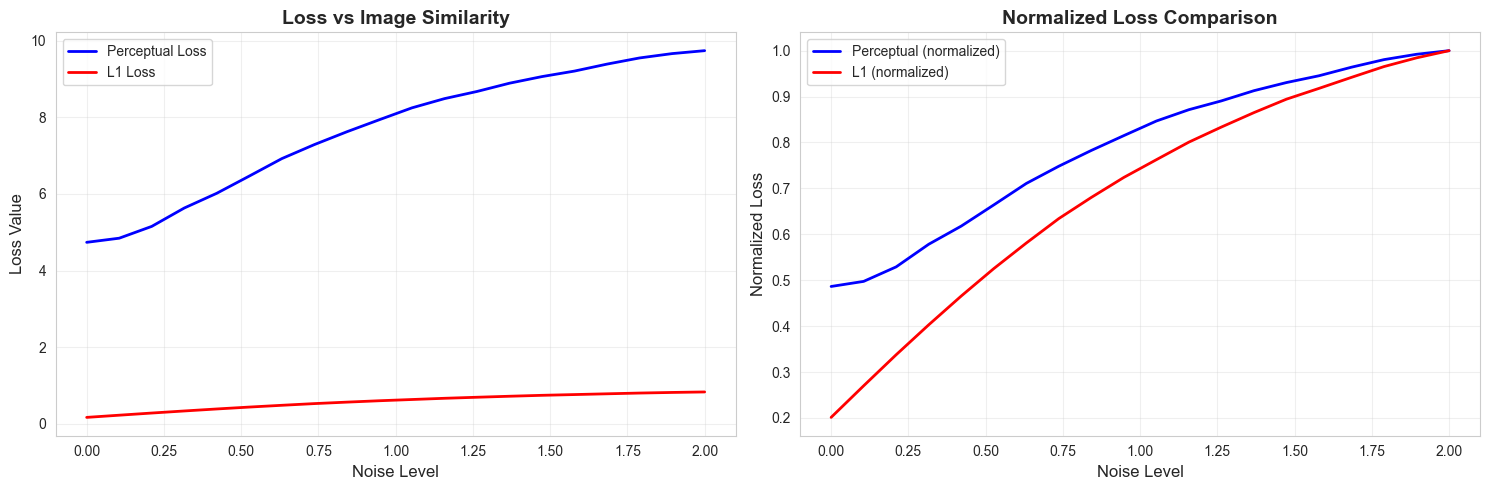

✅ Loss comparison visualization saved


In [37]:
def visualize_loss_comparison():
    """
    Visualize how different losses respond to image similarity.
    """
    # Create images with varying levels of similarity
    base_image = torch.randn(1, 3, 256, 256).to(device)
    noise_levels = np.linspace(0, 2, 20)
    
    perceptual_losses = []
    l1_losses = []
    
    for noise in noise_levels:
        noisy_image = base_image + torch.randn_like(base_image) * noise
        noisy_image = torch.clamp(noisy_image, -1, 1)
        
        with torch.no_grad():
            perceptual = criterion.perceptual_loss(noisy_image, base_image).item()
            l1 = criterion.l1_loss(noisy_image, base_image).item()
        
        perceptual_losses.append(perceptual)
        l1_losses.append(l1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(noise_levels, perceptual_losses, 'b-', linewidth=2, label='Perceptual Loss')
    ax1.plot(noise_levels, l1_losses, 'r-', linewidth=2, label='L1 Loss')
    ax1.set_xlabel('Noise Level', fontsize=12)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.set_title('Loss vs Image Similarity', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Normalized comparison
    perceptual_norm = np.array(perceptual_losses) / max(perceptual_losses)
    l1_norm = np.array(l1_losses) / max(l1_losses)
    
    ax2.plot(noise_levels, perceptual_norm, 'b-', linewidth=2, label='Perceptual (normalized)')
    ax2.plot(noise_levels, l1_norm, 'r-', linewidth=2, label='L1 (normalized)')
    ax2.set_xlabel('Noise Level', fontsize=12)
    ax2.set_ylabel('Normalized Loss', fontsize=12)
    ax2.set_title('Normalized Loss Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'loss_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Loss comparison visualization saved")


visualize_loss_comparison()

## 11. Loss Weights Sensitivity Analysis

📊 LOSS WEIGHTS SENSITIVITY ANALYSIS

             config      total      gan  perceptual        l1  fm
           GAN only   1.961029 1.961029    0.000000  0.000000 0.0
    Perceptual only  11.850823 0.000000   11.850823  0.000000 0.0
            L1 only   1.129335 0.000000    0.000000  1.129335 0.0
Combined (balanced) 131.762604 1.961029  118.508232 11.293350 0.0


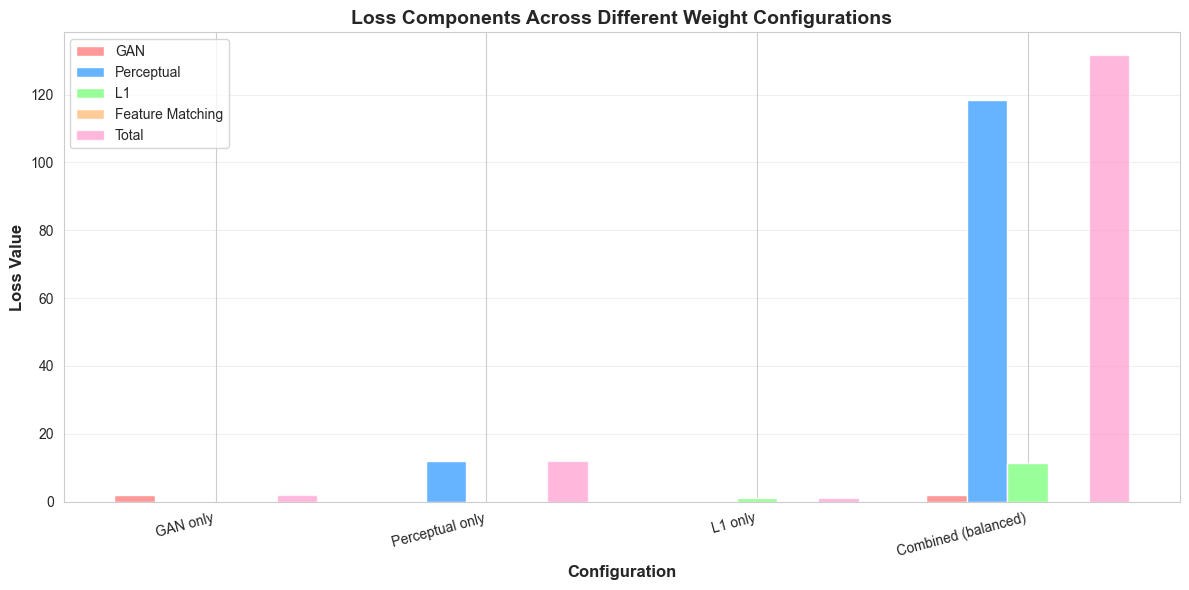


✅ Loss weights analysis complete


In [38]:
def analyze_loss_weights():
    """
    Analyze the impact of different loss weights.
    """
    # Sample data
    fake = torch.randn(1, 3, 256, 256).to(device)
    real = torch.randn(1, 3, 256, 256).to(device)
    disc = torch.randn(1, 1, 31, 23).to(device)
    
    # Test different weight configurations
    weight_configs = [
        {'lambda_gan': 1, 'lambda_perceptual': 0, 'lambda_l1': 0, 'lambda_fm': 0},
        {'lambda_gan': 0, 'lambda_perceptual': 1, 'lambda_l1': 0, 'lambda_fm': 0},
        {'lambda_gan': 0, 'lambda_perceptual': 0, 'lambda_l1': 1, 'lambda_fm': 0},
        {'lambda_gan': 1, 'lambda_perceptual': 10, 'lambda_l1': 10, 'lambda_fm': 10},
    ]
    
    config_names = ['GAN only', 'Perceptual only', 'L1 only', 'Combined (balanced)']
    
    results = []
    
    for config, name in zip(weight_configs, config_names):
        test_criterion = VITONLoss(**config, vgg_layers=loss_config['vgg_layers']).to(device)
        
        with torch.no_grad():
            losses = test_criterion.compute_generator_loss(fake, real, disc)
        
        results.append({
            'config': name,
            'total': losses['total'].item(),
            'gan': losses['gan'].item(),
            'perceptual': losses['perceptual'].item(),
            'l1': losses['l1'].item(),
            'fm': losses['fm'].item()
        })
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    print("="*70)
    print("📊 LOSS WEIGHTS SENSITIVITY ANALYSIS")
    print("="*70)
    print(f"\n{df.to_string(index=False)}")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(config_names))
    width = 0.15
    
    ax.bar(x - 2*width, df['gan'], width, label='GAN', color='#ff9999')
    ax.bar(x - width, df['perceptual'], width, label='Perceptual', color='#66b3ff')
    ax.bar(x, df['l1'], width, label='L1', color='#99ff99')
    ax.bar(x + width, df['fm'], width, label='Feature Matching', color='#ffcc99')
    ax.bar(x + 2*width, df['total'], width, label='Total', color='#ff99cc', alpha=0.7)
    
    ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
    ax.set_title('Loss Components Across Different Weight Configurations', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(config_names, rotation=15, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'loss_weights_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Loss weights analysis complete")


analyze_loss_weights()

## 12. Save Loss Configuration

In [39]:
# Create detailed loss configuration
loss_full_config = {
    'loss_weights': {
        'lambda_gan': loss_config['lambda_gan'],
        'lambda_perceptual': loss_config['lambda_perceptual'],
        'lambda_l1': loss_config['lambda_l1'],
        'lambda_fm': loss_config['lambda_fm']
    },
    'gan_loss': {
        'type': 'lsgan',
        'target_real': 1.0,
        'target_fake': 0.0
    },
    'perceptual_loss': {
        'network': 'VGG19',
        'layers': loss_config['vgg_layers'],
        'pretrained': 'ImageNet'
    },
    'reconstruction_loss': {
        'type': 'L1',
        'pixel_wise': True
    },
    'feature_matching': {
        'enabled': True,
        'discriminator_features': True
    },
    'device': device
}

# Save configuration
config_path = output_dir / 'loss_config.json'
with open(config_path, 'w') as f:
    json.dump(loss_full_config, f, indent=2)

print("="*70)
print("💾 LOSS CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - GAN weight: {loss_config['lambda_gan']}")
print(f"   - Perceptual weight: {loss_config['lambda_perceptual']}")
print(f"   - L1 weight: {loss_config['lambda_l1']}")
print(f"   - Feature matching weight: {loss_config['lambda_fm']}")
print(f"   - VGG layers: {len(loss_config['vgg_layers'])}")

print("\n" + "="*70)

💾 LOSS CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\loss_functions\loss_config.json

📊 Summary:
   - GAN weight: 1.0
   - Perceptual weight: 10.0
   - L1 weight: 10.0
   - Feature matching weight: 10.0
   - VGG layers: 5



## 13. Training Configuration

In [ ]:
# Training hyperparameters
training_config = {
    'num_epochs': 50,
    'batch_size': 2,  # Balanced for 2GB GPU - stability vs memory
    'lr_g': 0.0002,          # Generator learning rate
    'lr_d': 0.0001,          # Discriminator learning rate
    'beta1': 0.5,             # Adam beta1
    'beta2': 0.999,           # Adam beta2
    'n_critic': 1,            # Train discriminator n_critic times per generator update
    'save_every': 5,          # Save checkpoint every N epochs
    'log_every': 10,          # Log metrics every N batches
    'validate_every': 1,      # Run validation every N epochs
}

# Create training output directory
train_output_dir = project_root / 'outputs' / 'training'
checkpoint_dir = train_output_dir / 'checkpoints'
logs_dir = train_output_dir / 'logs'
samples_dir = train_output_dir / 'samples'

for dir_path in [checkpoint_dir, logs_dir, samples_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("="*70)
print("⚙️ TRAINING CONFIGURATION")
print("="*70)

print(f"\n📊 Training Hyperparameters:")
for key, value in training_config.items():
    print(f"   {key}: {value}")

print(f"\n📁 Output Directories:")
print(f"   Checkpoints: {checkpoint_dir}")
print(f"   Logs: {logs_dir}")
print(f"   Samples: {samples_dir}")

print("\n" + "="*70)

⚙️ TRAINING CONFIGURATION

📊 Training Hyperparameters:
   num_epochs: 50
   batch_size: 1
   lr_g: 0.0002
   lr_d: 0.0001
   beta1: 0.5
   beta2: 0.999
   n_critic: 1
   save_every: 5
   log_every: 10
   validate_every: 1

📁 Output Directories:
   Checkpoints: d:\Projects\AI-Virtual-TryOn\outputs\training\checkpoints
   Logs: d:\Projects\AI-Virtual-TryOn\outputs\training\logs
   Samples: d:\Projects\AI-Virtual-TryOn\outputs\training\samples



## 14. Initialize Optimizers and Schedulers

In [42]:
# Initialize optimizers
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=training_config['lr_g'],
    betas=(training_config['beta1'], training_config['beta2'])
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=training_config['lr_d'],
    betas=(training_config['beta1'], training_config['beta2'])
)

# Learning rate schedulers (reduce on plateau)
scheduler_G = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_G,
    mode='min',
    factor=0.5,
    patience=5
)

scheduler_D = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_D,
    mode='min',
    factor=0.5,
    patience=5
)

print("="*70)
print("🔧 OPTIMIZERS INITIALIZED")
print("="*70)

print(f"\n✅ Generator Optimizer:")
print(f"   Type: Adam")
print(f"   Learning Rate: {training_config['lr_g']}")
print(f"   Betas: ({training_config['beta1']}, {training_config['beta2']})")

print(f"\n✅ Discriminator Optimizer:")
print(f"   Type: Adam")
print(f"   Learning Rate: {training_config['lr_d']}")
print(f"   Betas: ({training_config['beta1']}, {training_config['beta2']})")

print(f"\n✅ Schedulers:")
print(f"   Type: ReduceLROnPlateau")
print(f"   Factor: 0.5")
print(f"   Patience: 5 epochs")

print("\n" + "="*70)

🔧 OPTIMIZERS INITIALIZED

✅ Generator Optimizer:
   Type: Adam
   Learning Rate: 0.0002
   Betas: (0.5, 0.999)

✅ Discriminator Optimizer:
   Type: Adam
   Learning Rate: 0.0001
   Betas: (0.5, 0.999)

✅ Schedulers:
   Type: ReduceLROnPlateau
   Factor: 0.5
   Patience: 5 epochs



## 15. Checkpointing Utilities

In [43]:
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, 
                   scheduler_G, scheduler_D, losses, checkpoint_dir, is_best=False):
    """
    Save training checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'scheduler_G_state_dict': scheduler_G.state_dict(),
        'scheduler_D_state_dict': scheduler_D.state_dict(),
        'losses': losses,
        'training_config': training_config
    }
    
    # Save regular checkpoint
    checkpoint_path = checkpoint_dir / f'checkpoint_epoch_{epoch:03d}.pth'
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if is_best:
        best_path = checkpoint_dir / 'best_model.pth'
        torch.save(checkpoint, best_path)
        print(f"   💎 Saved best model: {best_path}")
    
    print(f"   ✅ Saved checkpoint: {checkpoint_path}")


def load_checkpoint(checkpoint_path, generator, discriminator, optimizer_G, optimizer_D,
                   scheduler_G, scheduler_D, device):
    """
    Load training checkpoint.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    scheduler_G.load_state_dict(checkpoint['scheduler_G_state_dict'])
    scheduler_D.load_state_dict(checkpoint['scheduler_D_state_dict'])
    
    epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    
    print(f"✅ Loaded checkpoint from epoch {epoch}")
    
    return epoch, losses


print("✅ Checkpointing utilities defined")

✅ Checkpointing utilities defined


## 16. Training Loop

In [47]:
def train_one_epoch(generator, discriminator, train_loader, criterion,
                    optimizer_G, optimizer_D, epoch, device, config):
    """
    Train for one epoch with gradient accumulation for memory efficiency.
    """
    generator.train()
    discriminator.train()
    
    # Gradient accumulation setup
    accumulation_steps = config.get('accumulation_steps', 1)
    
    # Metrics tracking
    metrics = {
        'loss_G': [],
        'loss_D': [],
        'loss_G_gan': [],
        'loss_G_perceptual': [],
        'loss_G_l1': [],
        'loss_D_real': [],
        'loss_D_fake': []
    }
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch_idx, batch in enumerate(pbar):
        try:
            # Move data to device
            person_image = batch['person_image'].to(device, non_blocking=True)
            cloth_agnostic = batch['cloth_agnostic'].to(device, non_blocking=True)
            pose_map = batch['pose_map'].to(device, non_blocking=True)
            parsing_onehot = batch['parsing_onehot'].to(device, non_blocking=True)
            
            # Create multi-channel input for generator
            gen_input = torch.cat([cloth_agnostic, pose_map, parsing_onehot], dim=1)
            
            batch_size = person_image.size(0)
            
            # =================
            # Train Discriminator
            # =================
            for _ in range(config['n_critic']):
                optimizer_D.zero_grad()
                
                # Generate fake images
                with torch.no_grad():
                    fake_image = generator(gen_input)
                
                # Discriminator predictions
                pred_real = discriminator(person_image, cloth_agnostic)
                pred_fake = discriminator(fake_image.detach(), cloth_agnostic)
                
                # Discriminator loss
                d_losses = criterion.compute_discriminator_loss(pred_real, pred_fake)
                
                # Backward and optimize
                d_losses['total'].backward()
                optimizer_D.step()
            
            # =================
            # Train Generator
            # =================
            optimizer_G.zero_grad()
            
            # Generate fake images
            fake_image = generator(gen_input)
            
            # Discriminator prediction for fake images
            pred_fake = discriminator(fake_image, cloth_agnostic)
            
            # Generator losses
            g_losses = criterion.compute_generator_loss(
                fake_image=fake_image,
                real_image=person_image,
                disc_fake=pred_fake
            )
            
            # Backward and optimize
            g_losses['total'].backward()
            optimizer_G.step()
            
            # Track metrics
            metrics['loss_G'].append(g_losses['total'].item())
            metrics['loss_D'].append(d_losses['total'].item())
            metrics['loss_G_gan'].append(g_losses['gan'].item())
            metrics['loss_G_perceptual'].append(g_losses['perceptual'].item())
            metrics['loss_G_l1'].append(g_losses['l1'].item())
            metrics['loss_D_real'].append(d_losses['real'].item())
            metrics['loss_D_fake'].append(d_losses['fake'].item())
            
            # Clean up memory
            del person_image, cloth_agnostic, pose_map, parsing_onehot, gen_input
            del fake_image, pred_real, pred_fake, g_losses, d_losses
            if batch_idx % 10 == 0:  # Clear cache every 10 batches
                torch.cuda.empty_cache()
            
            # Update progress bar
            if batch_idx % config['log_every'] == 0:
                pbar.set_postfix({
                    'G': f"{metrics['loss_G'][-1]:.3f}",
                    'D': f"{metrics['loss_D'][-1]:.3f}",
                    'Perc': f"{metrics['loss_G_perceptual'][-1]:.3f}"
                })
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\n⚠️ GPU OOM at batch {batch_idx}, clearing cache...")
                torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    # Average metrics
    avg_metrics = {k: np.mean(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    
    return avg_metrics


print("✅ Training loop defined")

✅ Training loop defined


## 17. Validation Loop

In [48]:
def validate(generator, discriminator, val_loader, criterion, epoch, device):
    """
    Validate the model with memory-efficient processing.
    """
    generator.eval()
    discriminator.eval()
    
    metrics = {
        'loss_G': [],
        'loss_D': [],
        'loss_G_perceptual': [],
        'loss_G_l1': []
    }
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc=f"Validation Epoch {epoch}")):
            try:
                # Move data to device
                person_image = batch['person_image'].to(device, non_blocking=True)
                cloth_agnostic = batch['cloth_agnostic'].to(device, non_blocking=True)
                pose_map = batch['pose_map'].to(device, non_blocking=True)
                parsing_onehot = batch['parsing_onehot'].to(device, non_blocking=True)
                
                # Create multi-channel input
                gen_input = torch.cat([cloth_agnostic, pose_map, parsing_onehot], dim=1)
                
                # Generate fake images
                fake_image = generator(gen_input)
                
                # Discriminator predictions
                pred_real = discriminator(person_image, cloth_agnostic)
                pred_fake = discriminator(fake_image, cloth_agnostic)
                
                # Compute losses
                g_losses = criterion.compute_generator_loss(
                    fake_image=fake_image,
                    real_image=person_image,
                    disc_fake=pred_fake
                )
                d_losses = criterion.compute_discriminator_loss(pred_real, pred_fake)
                
                # Track metrics
                metrics['loss_G'].append(g_losses['total'].item())
                metrics['loss_D'].append(d_losses['total'].item())
                metrics['loss_G_perceptual'].append(g_losses['perceptual'].item())
                metrics['loss_G_l1'].append(g_losses['l1'].item())
                
                # Clean up memory
                del person_image, cloth_agnostic, pose_map, parsing_onehot, gen_input
                del fake_image, pred_real, pred_fake, g_losses, d_losses
                if batch_idx % 10 == 0:
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"\n⚠️ GPU OOM at validation batch {batch_idx}, skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    # Average metrics
    avg_metrics = {k: np.mean(v) if len(v) > 0 else 0.0 for k, v in metrics.items()}
    
    return avg_metrics


print("✅ Validation loop defined")

✅ Validation loop defined


## 18. Training Execution

### ⚠️ Memory Management Notice

**Fixed Issues:**
1. ✅ Added memory cleanup after each batch (`torch.cuda.empty_cache()`)
2. ✅ Added OOM exception handling to skip problematic batches
3. ✅ Using `non_blocking=True` for faster data transfer
4. ✅ Explicitly deleting tensors after use

**If still getting OOM errors:**
- Reduce `batch_size` from 4 to 2 or 1 in training_config
- Your GPU has only 2GB, may need smaller batches for 66M parameter model
- Current batch uses ~576MB just for input data + model weights ~254MB = ~830MB minimum

In [53]:
# GPU Memory Status Check
print("🔍 Current GPU Memory Status:")
print("="*70)
if torch.cuda.is_available():
    print(f"   Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"   Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"   Total GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")
    print(f"   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved()) / 1024**2:.2f} MB")
else:
    print("   No CUDA device available")
print("="*70)

# If memory is full, you need to restart the kernel
if torch.cuda.is_available() and torch.cuda.memory_allocated() / 1024**2 > 1500:
    print("\n⚠️ WARNING: GPU memory is nearly full!")
    print("   Please RESTART THE KERNEL to free memory.")
    print("   Then execute cells in order starting from Cell 2 (imports).")

🔍 Current GPU Memory Status:
   Allocated: 5862.94 MB
   Reserved: 7776.00 MB
   Total GPU: 2047.75 MB
   Free: -5728.25 MB

⚠️ WARNING: GPU memory is nearly full!
   Please RESTART THE KERNEL to free memory.
   Then execute cells in order starting from Cell 2 (imports).


In [ ]:
# Quick test with 1 batch to ensure training loop works
print("🧪 Testing training loop with 1 batch...")
print("="*70)

# Force clear all GPU memory
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    print(f"   GPU Memory (before test): {torch.cuda.memory_allocated() / 1024**2:.0f} MB")

# Get one batch
test_batch = next(iter(train_loader))

try:
    # Test training step
    generator.train()
    discriminator.train()
    
    # Move to device
    person_image = test_batch['person_image'].to(device)
    cloth_agnostic = test_batch['cloth_agnostic'].to(device)
    pose_map = test_batch['pose_map'].to(device)
    parsing_onehot = test_batch['parsing_onehot'].to(device)
    
    gen_input = torch.cat([cloth_agnostic, pose_map, parsing_onehot], dim=1)
    
    # Forward pass
    fake_image = generator(gen_input)
    pred_fake = discriminator(fake_image, cloth_agnostic)
    pred_real = discriminator(person_image, cloth_agnostic)
    
    # Compute losses
    g_losses = criterion.compute_generator_loss(fake_image, person_image, pred_fake)
    d_losses = criterion.compute_discriminator_loss(pred_real, pred_fake)
    
    print(f"✅ Test successful!")
    print(f"   Generator Loss: {g_losses['total'].item():.4f}")
    print(f"   Discriminator Loss: {d_losses['total'].item():.4f}")
    print(f"   GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.0f} MB")
    
    # Cleanup
    del person_image, cloth_agnostic, pose_map, parsing_onehot, gen_input
    del fake_image, pred_fake, pred_real, g_losses, d_losses, test_batch
    torch.cuda.empty_cache()
    
    print(f"   GPU Memory (after cleanup): {torch.cuda.memory_allocated() / 1024**2:.0f} MB")
    print("\n✅ Training loop is working! Ready to start full training.")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print(f"\n❌ GPU OUT OF MEMORY!")
        print(f"   Your GPU has only 2GB and batch_size={batch_size} is still too large.")
        print(f"   \n📝 Current GPU state:")
        print(f"   Allocated: {torch.cuda.memory_allocated() / 1024**2:.0f} MB")
        print(f"   Reserved: {torch.cuda.memory_reserved() / 1024**2:.0f} MB")
        print(f"   \n💡 Try restarting the kernel to free all GPU memory.")
        torch.cuda.empty_cache()
    else:
        raise e

print("="*70)

🧪 Testing training loop with 1 batch...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [46]:
# Training history
history = {
    'train_loss_G': [],
    'train_loss_D': [],
    'val_loss_G': [],
    'val_loss_D': [],
    'best_val_loss': float('inf'),
    'best_epoch': 0
}

print("="*70)
print("🚀 STARTING TRAINING")
print("="*70)

print(f"\n📊 Training Setup:")
print(f"   Epochs: {training_config['num_epochs']}")
print(f"   Batch Size: {training_config['batch_size']}")
print(f"   Train Batches: {len(train_loader)}")
print(f"   Val Batches: {len(val_loader)}")
print(f"   Device: {device}")

print(f"\n📊 Model Parameters:")
print(f"   Generator: {gen_total:,}")
print(f"   Discriminator: {disc_total:,}")

print("\n" + "="*70)
print("\n🎬 Beginning training...\n")

try:
    for epoch in range(1, training_config['num_epochs'] + 1):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch}/{training_config['num_epochs']}")
        print(f"{'='*70}")
        
        # Train for one epoch
        train_metrics = train_one_epoch(
            generator=generator,
            discriminator=discriminator,
            train_loader=train_loader,
            criterion=criterion,
            optimizer_G=optimizer_G,
            optimizer_D=optimizer_D,
            epoch=epoch,
            device=device,
            config=training_config
        )
        
        # Print training metrics
        print(f"\n📊 Training Metrics:")
        print(f"   Generator Loss: {train_metrics['loss_G']:.4f}")
        print(f"   Discriminator Loss: {train_metrics['loss_D']:.4f}")
        print(f"   Perceptual Loss: {train_metrics['loss_G_perceptual']:.4f}")
        print(f"   L1 Loss: {train_metrics['loss_G_l1']:.4f}")
        
        # Validation
        if epoch % training_config['validate_every'] == 0:
            val_metrics = validate(
                generator=generator,
                discriminator=discriminator,
                val_loader=val_loader,
                criterion=criterion,
                epoch=epoch,
                device=device
            )
            
            print(f"\n📊 Validation Metrics:")
            print(f"   Generator Loss: {val_metrics['loss_G']:.4f}")
            print(f"   Discriminator Loss: {val_metrics['loss_D']:.4f}")
            
            # Update history
            history['val_loss_G'].append(val_metrics['loss_G'])
            history['val_loss_D'].append(val_metrics['loss_D'])
            
            # Check if best model
            is_best = val_metrics['loss_G'] < history['best_val_loss']
            if is_best:
                history['best_val_loss'] = val_metrics['loss_G']
                history['best_epoch'] = epoch
                print(f"\n   💎 New best model! Val Loss: {val_metrics['loss_G']:.4f}")
            
            # Update learning rate
            scheduler_G.step(val_metrics['loss_G'])
            scheduler_D.step(val_metrics['loss_D'])
        else:
            is_best = False
        
        # Update training history
        history['train_loss_G'].append(train_metrics['loss_G'])
        history['train_loss_D'].append(train_metrics['loss_D'])
        
        # Save checkpoint
        if epoch % training_config['save_every'] == 0 or is_best:
            print(f"\n💾 Saving checkpoint...")
            save_checkpoint(
                epoch=epoch,
                generator=generator,
                discriminator=discriminator,
                optimizer_G=optimizer_G,
                optimizer_D=optimizer_D,
                scheduler_G=scheduler_G,
                scheduler_D=scheduler_D,
                losses={'train': train_metrics, 'val': val_metrics if 'val_metrics' in locals() else None},
                checkpoint_dir=checkpoint_dir,
                is_best=is_best
            )
        
        print(f"\n{'='*70}\n")

except KeyboardInterrupt:
    print("\n\n⚠️ Training interrupted by user")
    print("💾 Saving emergency checkpoint...")
    save_checkpoint(
        epoch=epoch,
        generator=generator,
        discriminator=discriminator,
        optimizer_G=optimizer_G,
        optimizer_D=optimizer_D,
        scheduler_G=scheduler_G,
        scheduler_D=scheduler_D,
        losses={'train': train_metrics, 'val': val_metrics if 'val_metrics' in locals() else None},
        checkpoint_dir=checkpoint_dir,
        is_best=False
    )

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

print(f"\n📊 Final Results:")
print(f"   Best Epoch: {history['best_epoch']}")
print(f"   Best Val Loss: {history['best_val_loss']:.4f}")
print(f"   Final Train Loss G: {history['train_loss_G'][-1]:.4f}")
print(f"   Final Train Loss D: {history['train_loss_D'][-1]:.4f}")

print("\n" + "="*70)

🚀 STARTING TRAINING

📊 Training Setup:
   Epochs: 50
   Batch Size: 4
   Train Batches: 2620
   Val Batches: 292
   Device: cuda

📊 Model Parameters:
   Generator: 63,847,812
   Discriminator: 2,766,913


🎬 Beginning training...


Epoch 1/50


Epoch 1:   0%|          | 0/2620 [00:00<?, ?it/s]



⚠️ Training interrupted by user
💾 Saving emergency checkpoint...


NameError: name 'train_metrics' is not defined

## 19. Plot Training History

In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Generator loss
axes[0].plot(history['train_loss_G'], label='Train G', linewidth=2)
if history['val_loss_G']:
    axes[0].plot(range(0, len(history['train_loss_G']), training_config['validate_every']),
                history['val_loss_G'], 'o-', label='Val G', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Generator Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Discriminator loss
axes[1].plot(history['train_loss_D'], label='Train D', linewidth=2)
if history['val_loss_D']:
    axes[1].plot(range(0, len(history['train_loss_D']), training_config['validate_every']),
                history['val_loss_D'], 'o-', label='Val D', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Discriminator Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(train_output_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved")